# 0.0. IMPORTS

In [2]:
import datetime
import pandas as pd
import numpy as np
import random
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec

from inflection import underscore
from IPython.display import Image
from IPython.core.display import HTML
from scipy import stats as ss

import xgboost as xgb
from boruta import BorutaPy
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from category_encoders.one_hot import OneHotEncoder

## 0.1. Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    
    display(HTML ('<style>.container { width:95% !important; } </style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows=50
    pd.set_option('display.expand_frame_repr', False)
       
    sns.set()
    
jupyter_settings()

In [ ]:
lr = LinearRegression()
lr_result_cv = cross_validation( x_training_for_k_fold, 5, 'Linear Regression', lr, cols_selected_boruta, verbose=False)
lr_result_cv

In [41]:
def cross_validation( x_training_k_fold, kfold, model_name, model, columns_selected,verbose=False):
    
    x_training = x_training_k_fold.copy()
    
    final_performance = pd.DataFrame()

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'KFold Number: {k} of {model_name}')

        # start and end date for validation
        validation_start_date = x_training['date'].max()-datetime.timedelta(weeks= k * 6)
        validation_end_date = x_training['date'].max()-datetime.timedelta(weeks= (k-1) * 6)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        
        # PREPARATION
        my_data_preparation = DataPrepatarion(training)

        # return train data
        training = my_data_preparation.get_train_data()
        
        xtraining = training[columns_selected].copy()
        ytraining = training['sales'].copy()
        
        # validation data
        validation = my_data_preparation.transform_a_data(validation)
        
        xvalidation = validation[columns_selected].copy()
        yvalidation = validation['sales'].copy()

        
        # model
        m = model.fit(xtraining, ytraining)
        # predict
        yhat = m.predict(xvalidation)
        # performance
        m_performance = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        final_performance = final_performance.append(m_performance)
    
    if verbose:
        print('\n')
        print(final_performance)
        print('\n')
    result_mean = final_performance.groupby('MODEL_NAME').mean().apply(np.round, args=(2,))
    result_std = final_performance.groupby('MODEL_NAME').std().apply(np.round, args=(2,))
    result = result_mean.astype(str) + ' +/- ' + result_std.astype(str)
    
    return result.reset_index()


def ml_error(model_name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)

    mape = mean_absolute_percentage_error(y_true, y_pred)

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    return pd.DataFrame({'MODEL_NAME':model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])


def cramer_v(x, y):
    cm = pd.crosstab(x, y).values

    chi2 = ss.chi2_contingency(cm)[0]    
    n = cm.sum()
    r, k = cm.shape
    
    # bias correction
    chi2cor = max(0, chi2 - ((k-1) * (r-1)) / (n-1))
    kcor = k - ((k-1)**2) / (n-1)
    rcor = r - ((r-1)**2) / (n-1)
    
    return np.sqrt((chi2cor/n)  / (min(kcor-1,rcor-1)))


## 0.2. Loading Data

!cd  && forfiles

In [4]:
df_sales_raw = pd.read_csv('../../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../../data/store.csv')

# merging --> key column = Store
df_raw = df_sales_raw.merge(df_store_raw, on='Store')

# 1.0. PASSO 01 - DATA DESCRIPTION

In [5]:
df01 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
# lower and separating by _
df01.columns = df_raw.columns.to_series().apply(lambda x: underscore(x))

## 1.2. Data Dimensions

In [7]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [8]:
df01.sample(3)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
572428,628,5,2014-07-18,6253,776,1,1,0,0,a,c,2180.0,NaN,NaN,0,NaN,NaN,NaN
594156,653,5,2015-07-03,7340,547,1,1,0,1,d,c,7520.0,7.0,2014.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
70124,77,7,2013-07-21,0,0,0,0,0,1,d,c,1090.0,8.0,2009.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct"


In [9]:
df01.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
df01['date'] = pd.to_datetime(df01['date'])

## 1.4. Check NA

In [11]:
df01.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA's

In [12]:
#competition_distance --> fill with a really big distante --> implies --> no competition
df01['competition_distance'].fillna(max(df01['competition_distance']) * 3,
                                    inplace=True)

#### The next 4 "since" attributes --> Filling the respective label ( month, year) of the sale date
#### Because if since month = sale month --> the difference will be 0
#competition_open_since_month --> fill with the month of the sale
df01['competition_open_since_month'].fillna(
    df01.loc[df01['competition_open_since_month'].isna(), 'date'].dt.month,
    inplace=True)

#competition_open_since_year --> fill with the year of the sale
df01['competition_open_since_year'].fillna(
    df01.loc[df01['competition_open_since_year'].isna(), 'date'].dt.year,
    inplace=True)

#promo2_since_week --> fill with the week of the sale
df01['promo2_since_week'].fillna(df01.loc[df01['promo2_since_week'].isna(),
                                          'date'].dt.isocalendar().week,
                                 inplace=True)

#promo2_since_year --> fill with the year of the sale
df01['promo2_since_year'].fillna(df01.loc[df01['promo2_since_year'].isna(),
                                          'date'].dt.year,
                                 inplace=True)

#promo_interval
df01['promo_interval'] = df01['promo_interval'].str.replace(
    'Sept', 'Sep')  # en_US format
df01['promo_interval'].fillna(0, inplace=True)  # there's no promo_interval

#df01['sale_month'] = df01['date'].dt.strftime('%b') --> deletar
# creating a column to know if the sale is in a promo month
df01['is_promo'] = df01[['promo_interval','date']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1
    if x['date'].strftime('%b') in x['promo_interval'] else 0,
    axis=1)

## 1.6. Verifying Types

In [13]:
df01.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      Float64
promo2_since_year                      float64
promo_interval                          object
is_promo                                 int64
dtype: object

In [14]:
df01['competition_open_since_month'] = df01['competition_open_since_month'].astype('int64')
df01['competition_open_since_year'] = df01['competition_open_since_year'].astype('int64')

df01['promo2_since_week'] = df01['promo2_since_week'].astype('int64')
df01['promo2_since_year'] = df01['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistics

In [15]:
num_attributes = df01.select_dtypes(include=['int64','float64'])
cat_attributes = df01.select_dtypes(include=['object'])

### 1.7.1. Numerical Attributes

In [16]:
m1 = pd.DataFrame()
# Central tendency - mean, median
m1['mean'] = num_attributes.apply(np.mean)
m1['median'] =  num_attributes.apply(np.median)
# Dispersion - str, min, max, range, skew, kurtosis
m1['std'] = num_attributes.apply(np.std)
m1['min'] = num_attributes.apply(min)
m1['max'] = num_attributes.apply(max)
m1['range'] = num_attributes.apply(lambda x: x.max() - x.min())
m1['skew'] = num_attributes.apply(lambda x: x.skew())
m1['kurtosis'] = num_attributes.apply(lambda x: x.kurtosis())

# just realocating columns
metrics = m1[['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]
metrics

,min,max,range,mean,median,std,skew,kurtosis
store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
competition_distance,20.0,227580.0,227560.0,6007.076294,2330.0,13682.728423,11.512969,177.136255
competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\Miguel\anaconda3\envs\dsemproducao_venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

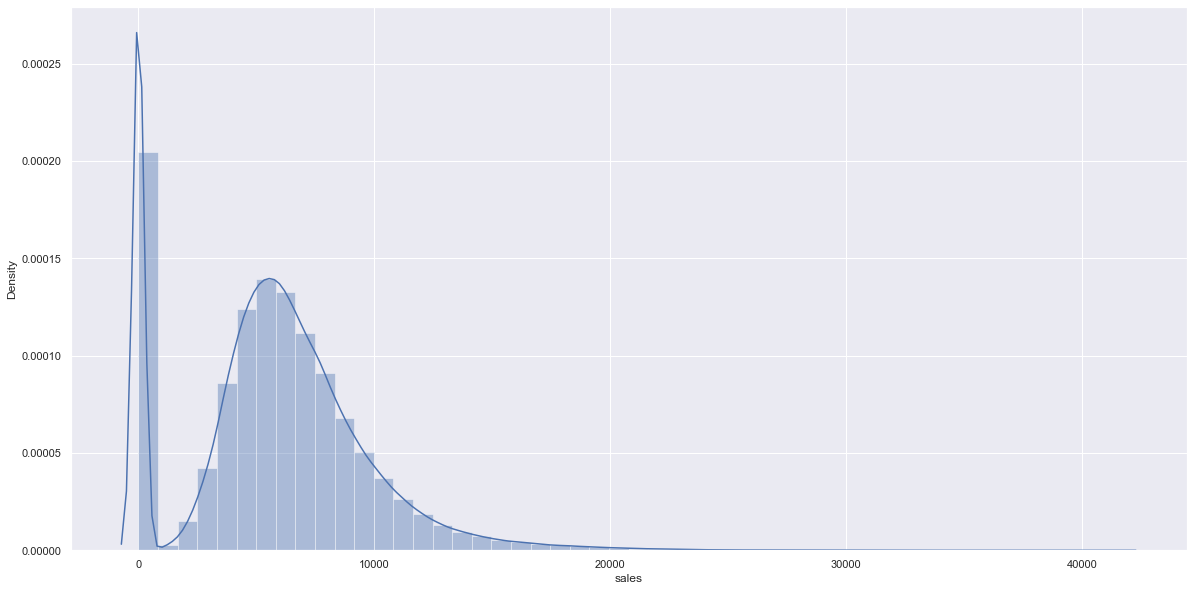

In [17]:
sns.distplot(df01['sales'])

### 1.7.1. Categorical Attributes

In [18]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

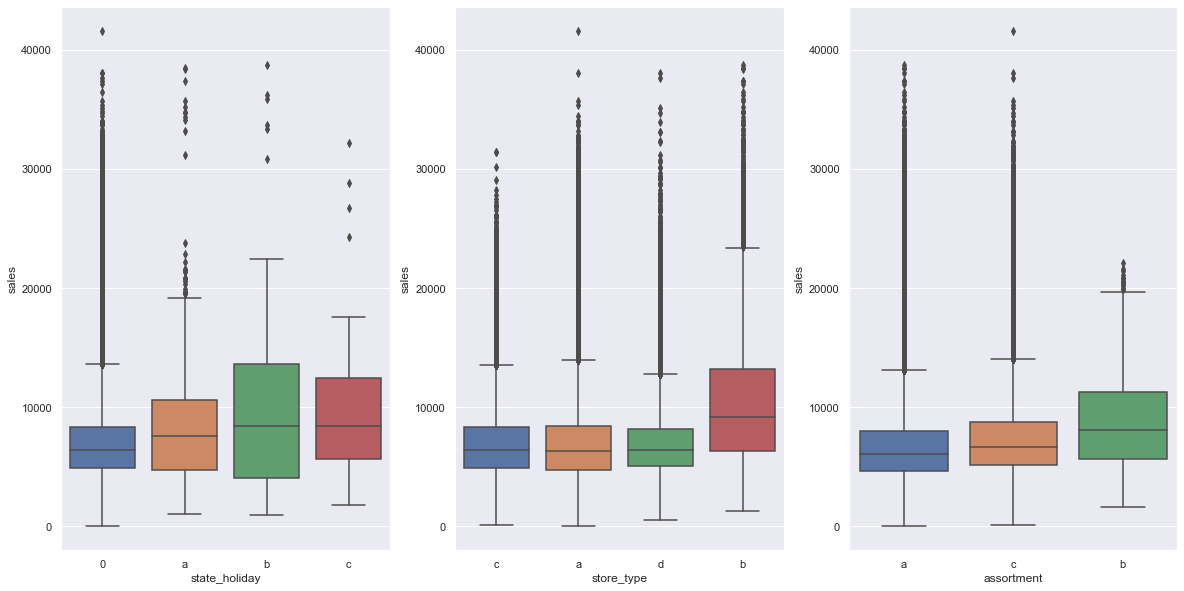

In [19]:
aux1 = df01.loc[(df01['state_holiday'] != 0) & (df01['sales'] >0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [20]:
df02 = df01.copy()

## 2.1. Mapa Mental de Hipoteses

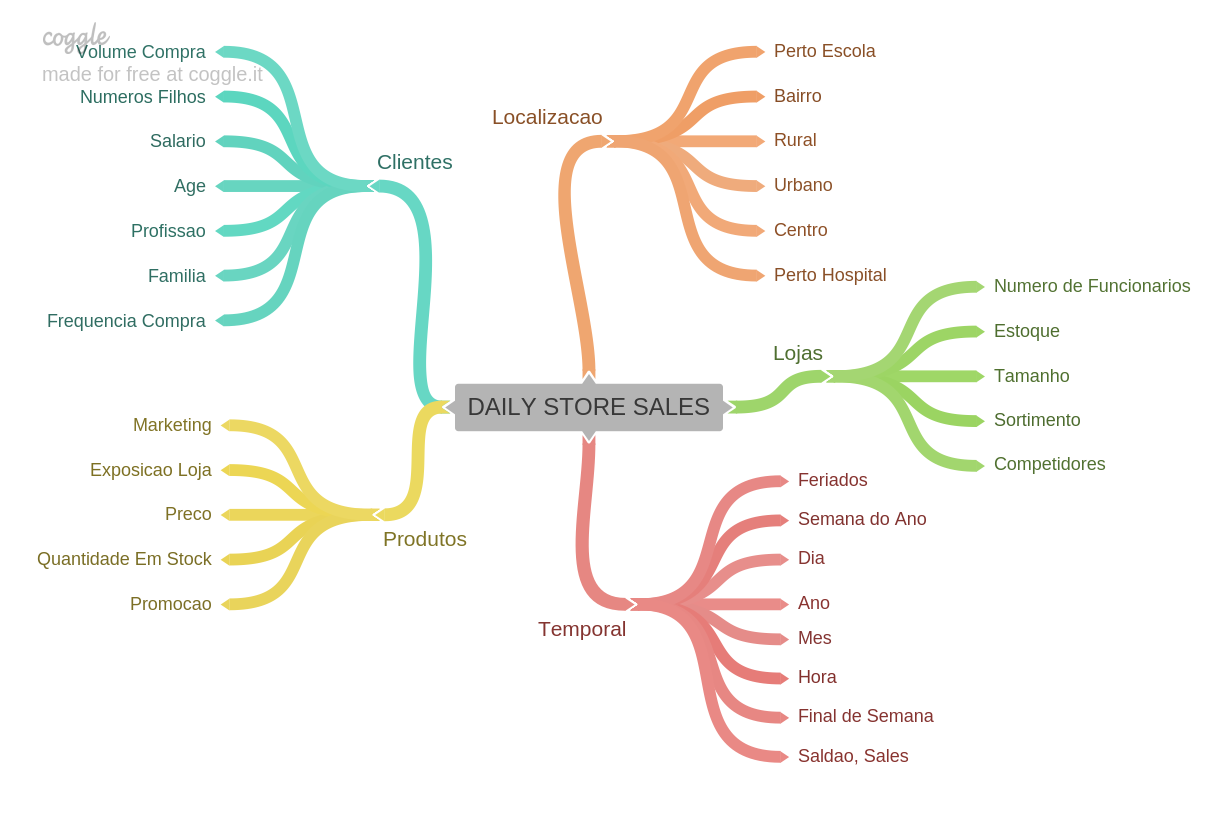

In [21]:
Image('../img/MindMapHypothesis.png')

## 2.2. Criacao das Hipoteses

### 2.1.1. Hipoteses Loja

<b>1. Lojas com maior quadro de funcionários deveriam vender mais
    
<b>2. Lojas com maior estoque deveriam vender mais
    
<b>3. Lojas com maior porte deveriam vender mais
    
<b>4. Lojas com maior sortimento deveriam vender mais

<b>5. Lojas com competidores mais proximos deveriam vender menos
    
<b>6. Lojas que têm competidores mais tempo deveriam vender mais (estabilização)

### 2.1.2. Hipoteses Produto

<b>1. Lojas quem investem mais em Marketing deveriam vender mais
    
<b>2. Lojas que expõe mais os produtos nas vitrines deveriam vender mais
    
<b>3. Lojas quem tem precos menores dos produtos deveriam vender mais
   
<b>4. Lojas com promoções mais agressivas deveriam vender mais
    
<b>5. Lojas com promoções ativas por mais tempo deveriam vender mais
    
<b>6. Lojas com mais dias de promoção deveriam vender mais
    
<b>7. Lojas com mais promoções consecutivas deveriam vender mais

### 2.1.3. Hipoteses Tempo

<b>1. Lojas abertas durante o feriado de Natal deveriam vender mais
    
<b>2. Lojas deveriam vender mais ao longo dos anos

<b>3. Lojas deveriam vender mais no segundo semestre do ano
    
<b>4. Lojas deveriam vender mais depois do dia 10 de cada mês
    
<b>5. Lojas deveriam vender menos aos finais de semana
    
<b>6. Lojas deveriam vender menos durante os feriados escolares

## 2.3. Lista final de hipoteses
--> Selecionando as hipoteses que posso validar com os dados nesse momento

<b>1. Lojas com maior sortimento deveriam vender mais

<b>2. Lojas com competidores mais proximos deveriam vender menos
    
<b>3. Lojas que têm competidores mais tempo deveriam vender mais (estabilização)

<b>4. Lojas com promoções ativas por mais tempo deveriam vender mais
    
<b>5. Lojas com mais dias de promoção deveriam vender mais
    
<b>6. Lojas com mais promoções consecutivas deveriam vender mais

<b>7. Lojas abertas durante o feriado de Natal deveriam vender mais
    
<b>8. Lojas deveriam vender mais ao longo dos anos

<b>9. Lojas deveriam vender mais no segundo semestre do ano
    
<b>10. Lojas deveriam vender mais depois do dia 10 de cada mês
    
<b>11. Lojas deveriam vender menos aos finais de semana
    
<b>12. Lojas deveriam vender menos durante os feriados escolares

## 2.4. Feature Engineering

In [22]:
df02['date']

0         2015-07-31
1         2015-07-30
2         2015-07-29
3         2015-07-28
4         2015-07-27
             ...    
1017204   2013-01-05
1017205   2013-01-04
1017206   2013-01-03
1017207   2013-01-02
1017208   2013-01-01
Name: date, Length: 1017209, dtype: datetime64[ns]

In [23]:
# year
df02['year'] = df02['date'].dt.year

# month
df02['month'] = df02['date'].dt.month

# day
df02['day'] = df02['date'].dt.day

# week of year
df02['week_of_year'] = df02['date'].dt.isocalendar().week

# year week
df02['year_week'] = df02['date'].dt.strftime('%Y-%V')

# competition since
df02['competition_since'] = pd.to_datetime(df02['competition_open_since_year'].astype(str) + 
               '-' + df02['competition_open_since_month'].astype(str), format='%Y-%m')

df02['competition_time_month'] = (( df02['date'] - df02['competition_since'])/30).dt.days


# promo since -- > needs a day of week to transform to date
df02['promo_since'] = pd.to_datetime(
    df02['promo2_since_year'].astype(str) + '-' 
    + df02['promo2_since_week'].astype(str) + '-0',  format='%G-%V-%w')

df02['promo_time_week'] = ((df02['date'] - df02['promo_since'])/7).dt.days# how many weeks in promo

# assorment
dic_assorment = {'a': 'basic', 'b': 'extra', 'c': 'extended'}
df02['assortment'] = df02['assortment'].replace(dic_assorment)

# state holiday
dic_holidays = {'a': 'public_holiday', 'b': 'easter_holiday', 'c': 'christmas', '0':'regular_day'}
df02['state_holiday'] = df02['state_holiday'].replace(dic_holidays)

# removing promo_inverval
df02 = df02.drop(columns=['promo_interval'])

# 3.0. PASSO 03 - FILTRAGEM DE VARIAVEIS

In [24]:
df03 = df02.copy()

## 3.1. Filtragem das Linhas

In [25]:
df03 = df03[(df03['open'] != 0) & (df03['sales'] > 0)]

In [26]:
df03.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'month', 'day', 'week_of_year',
       'year_week', 'competition_since', 'competition_time_month',
       'promo_since', 'promo_time_week'],
      dtype='object')

## 3.2. Filtragem das Colunas

In [27]:
cols_drop = ['customers', 'open']
df03 = df03.drop(columns=cols_drop)

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [28]:
df04 = df03.copy()
pickle.dump(df04, open('../../data/intermediary_data_df04.pkl', 'wb'))

## 4.1. Analise Univariada

### 4.1.1. Response Variable

C:\Users\Miguel\anaconda3\envs\dsemproducao_venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


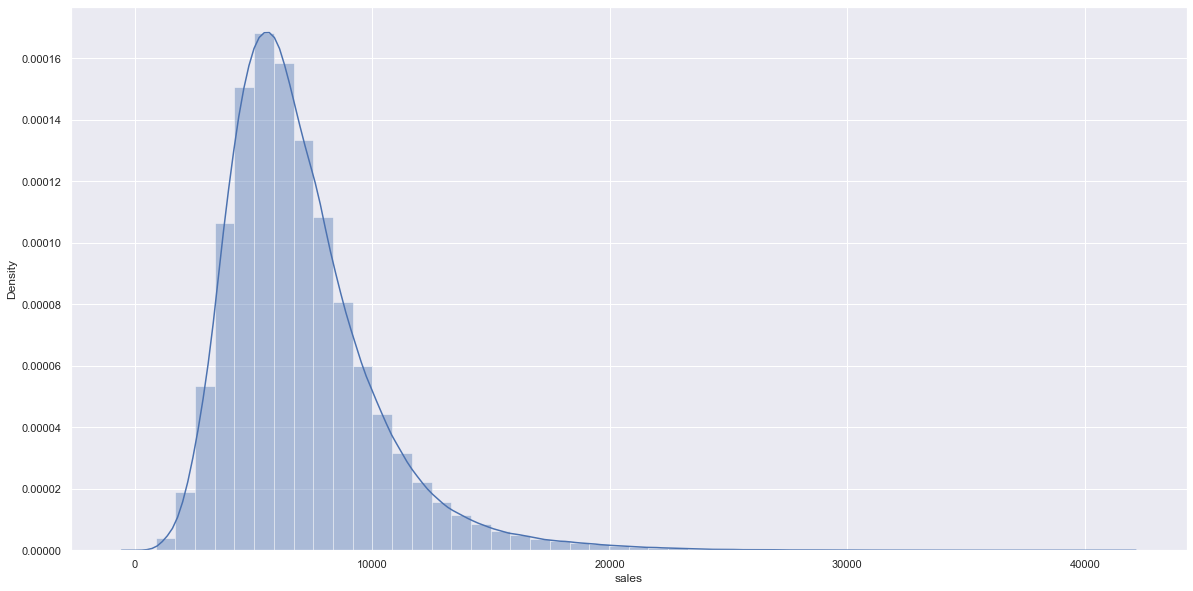

In [48]:
sns.distplot(df03['sales'])
plt.show()

### 4.1.2. Numerical Variable

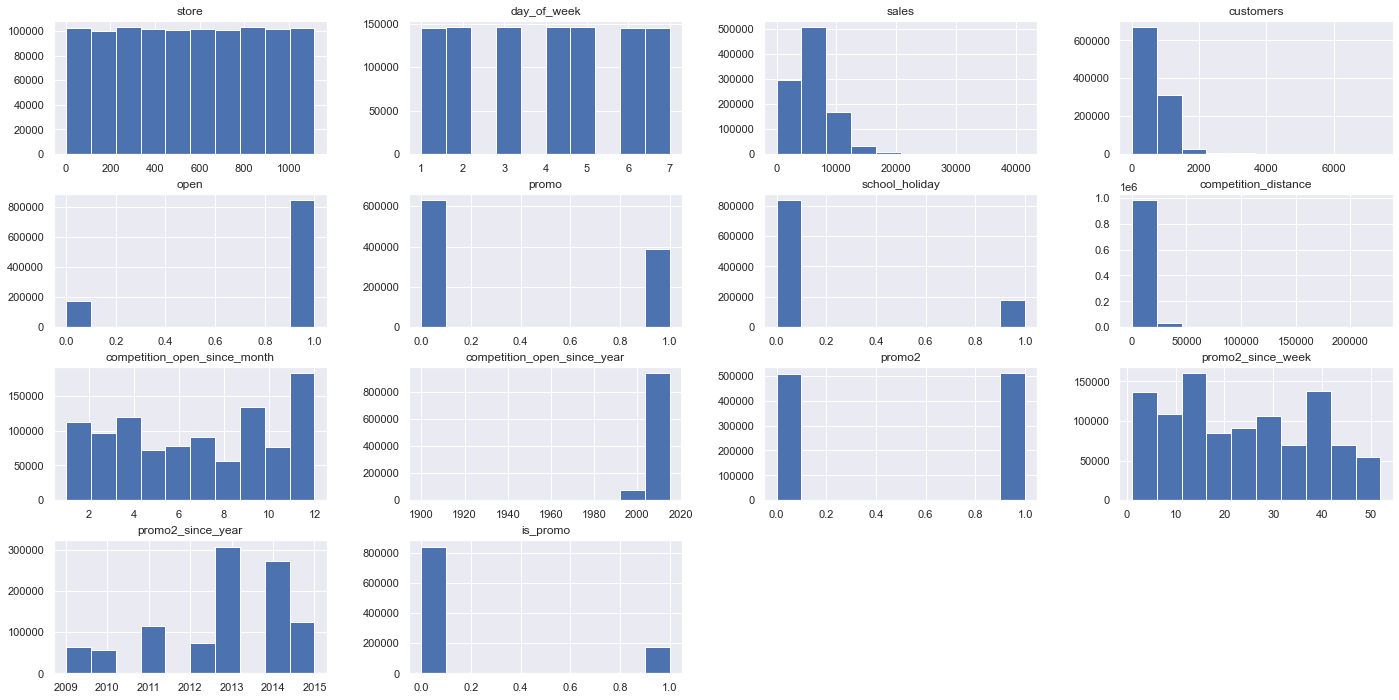

In [30]:
num_attributes.hist();

### 4.1.3. Categorical Variable

In [31]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval
0,0,c,a,0
1,0,c,a,0
2,0,c,a,0
3,0,c,a,0
4,0,c,a,0


C:\Users\Miguel\anaconda3\envs\dsemproducao_venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Miguel\anaconda3\envs\dsemproducao_venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Miguel\anaconda3\envs\dsemproducao_venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

<AxesSubplot:xlabel='sales', ylabel='Density'>

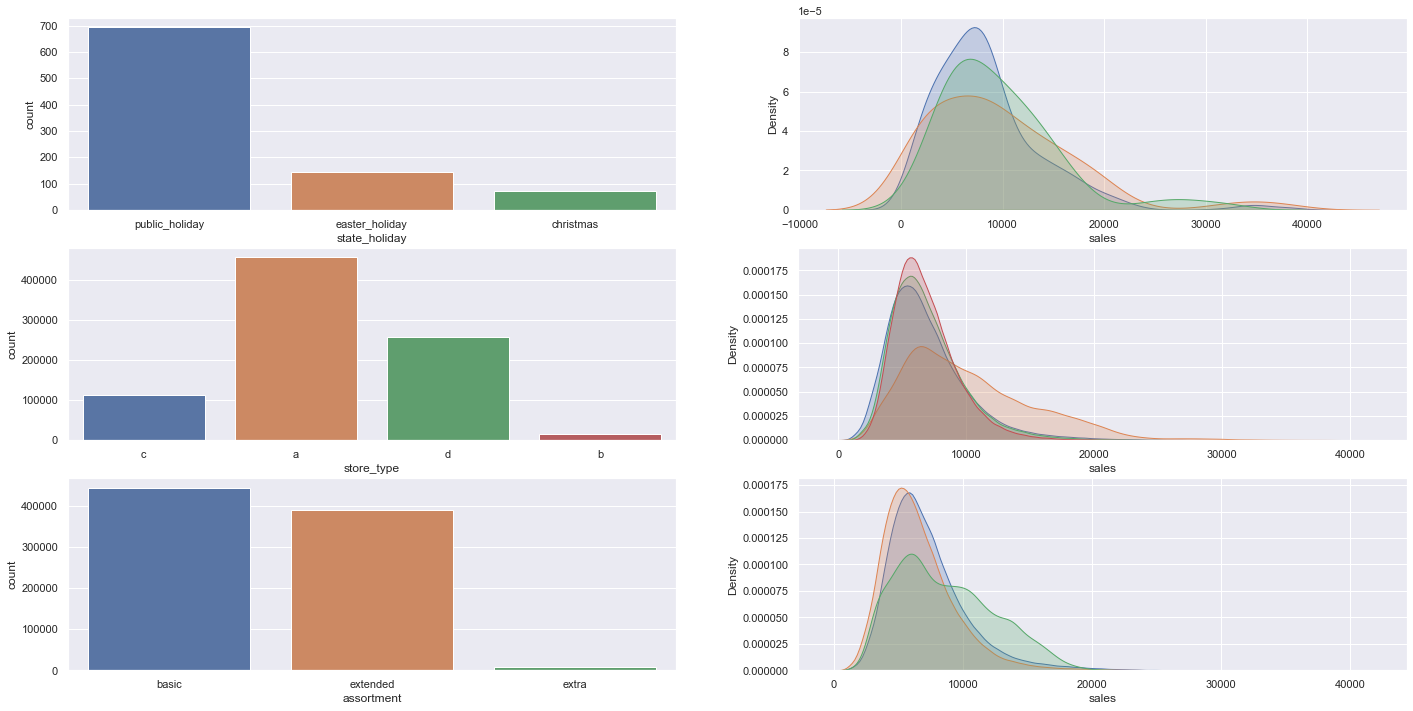

In [32]:
# state_holiday
plt.subplot(3,2,1)
a = df04[df04['state_holiday'] != 'regular_day'] # just because regular day is massive big
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df04[df04['state_holiday'] == 'public_holiday']['sales'],label= 'public_holiday',shade=True) # shade=more transparent
sns.kdeplot(df04[df04['state_holiday'] == 'easter_holiday']['sales'],label= 'easter_holiday',shade=True)
sns.kdeplot(df04[df04['state_holiday'] == 'christmas']['sales'],label= 'christmas',shade=True)
#sns.kdeplot(df04[df04['state_holiday'] == 'regular_day']['sales'],label= 'regular_day',shade=True)

# store_type
plt.subplot(3,2,3)
sns.countplot(df04['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df04[df04['store_type'] == 'a']['sales'],label= 'a',shade=True) # shade=more transparent
sns.kdeplot(df04[df04['store_type'] == 'b']['sales'],label= 'b',shade=True)
sns.kdeplot(df04[df04['store_type'] == 'c']['sales'],label= 'c',shade=True)
sns.kdeplot(df04[df04['store_type'] == 'd']['sales'],label= 'd',shade=True)

# assortment
plt.subplot(3,2,5)
sns.countplot(df04['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df04[df04['assortment'] == 'extended']['sales'],label= 'extended',shade=True) # shade=more transparent
sns.kdeplot(df04[df04['assortment'] == 'basic']['sales'],label= 'basic',shade=True)
sns.kdeplot(df04[df04['assortment'] == 'extra']['sales'],label= 'extra',shade=True)

## 4.2. Analise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais
    
<b><font color='green'>VERDADEIRO</font> - Apesar de basic ter um maior somatorio de vendas (e lojas), o extended possui maior média.

Obs: Tamanho de sortimento --- basic < extra < extended 

Number of stores/Assortment
basic       593
extended    513
extra         9
Name: Assortment, dtype: int64


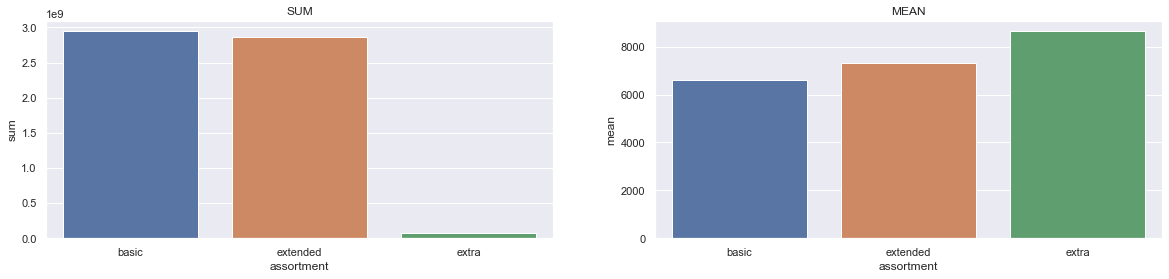

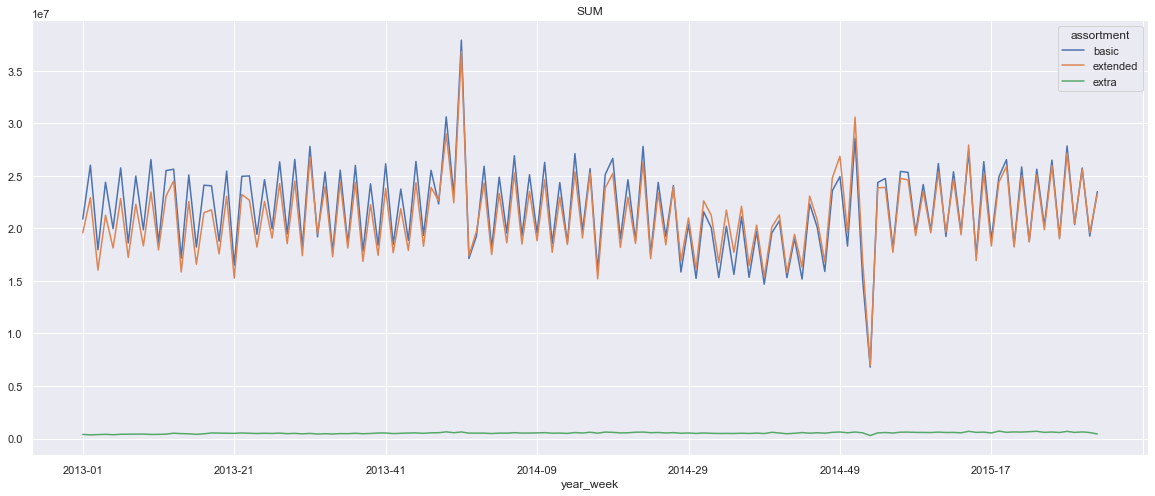

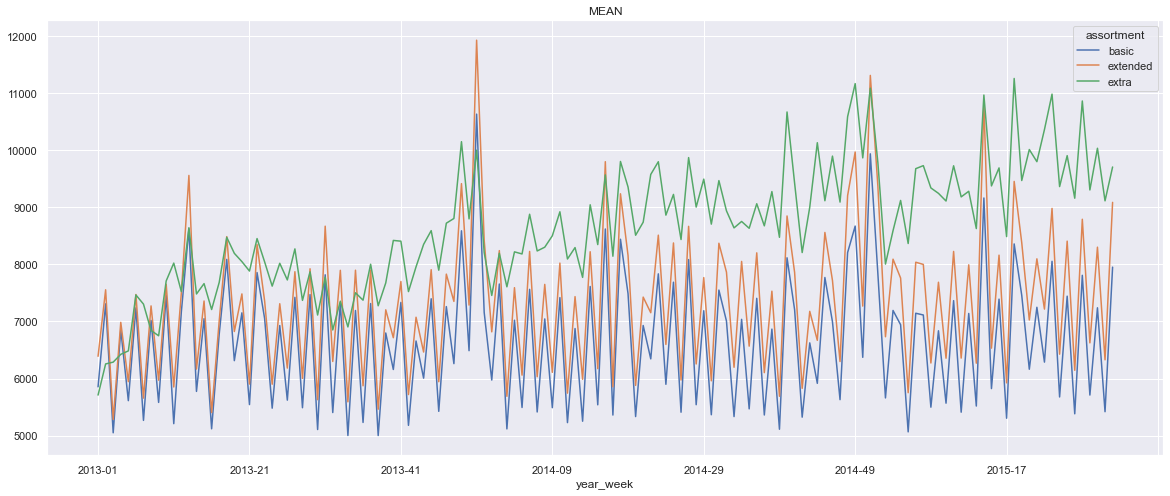

In [60]:
print('Number of stores/Assortment')
print(df_store_raw['Assortment'].value_counts().rename({'a':'basic', 'b': 'extra', 'c': 'extended'}))

h1_group = df04[['assortment', 'sales']].groupby('assortment')
h1_df = pd.DataFrame({
    'count': h1_group.count()['sales'],
    'mean': h1_group.mean()['sales'],
    'sum': h1_group.sum()['sales']
})

plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.barplot(x=h1_df.index, y='sum', data=h1_df).set_title('SUM')
plt.subplot(1,2,2)
sns.barplot(x=h1_df.index, y='mean', data=h1_df).set_title('MEAN')

plt.show()


h1_group_week = df04[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment'])
aux1 = h1_group_week.sum().reset_index().pivot(index='year_week', columns='assortment', values='sales')
aux2 = h1_group_week.mean().reset_index().pivot(index='year_week', columns='assortment', values='sales')
aux1.plot(title='SUM', figsize=(20,8))
aux2.plot(title='MEAN', figsize=(20,8))
plt.show()

### H2. Lojas com competidores mais proximos deveriam vender menos
    
<b><font color='red'>FALSO</font> - Aparentemente a média de vendas não sofre mudanças substanciais com a distância dos competidores.

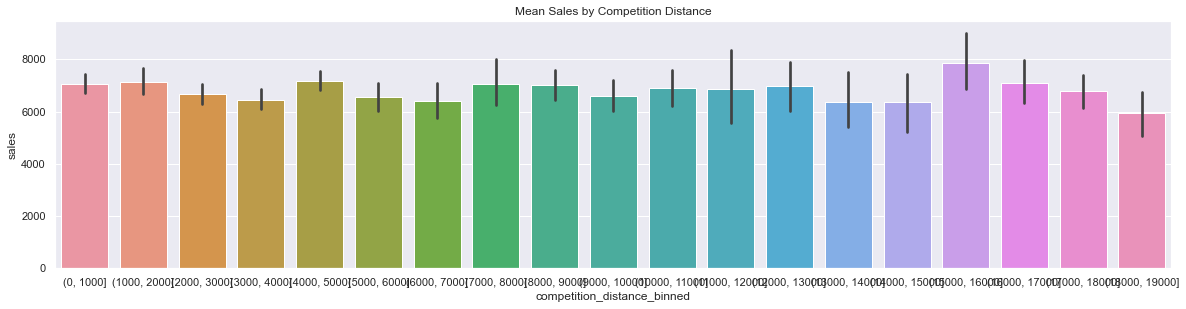

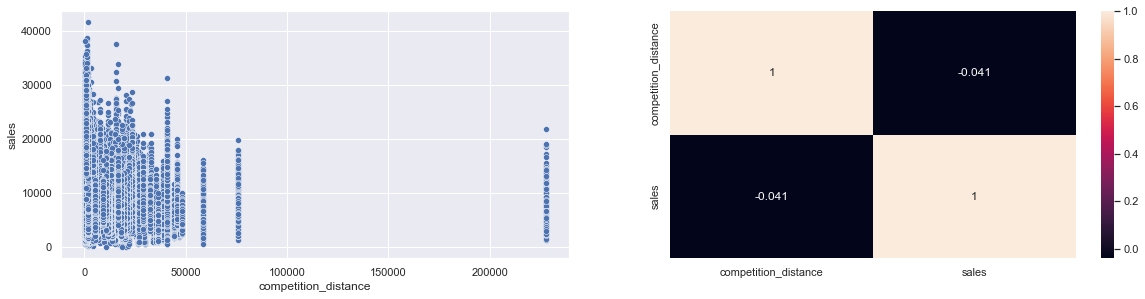

In [51]:
bins = list(np.arange(0,20000,1000))

grid = GridSpec(2,2)


# MEAN
aux2 = df04[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

aux2['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)

plt.subplot(grid[0,:])
sns.barplot(x='competition_distance_binned', y='sales', data=aux2).set_title('Mean Sales by Competition Distance')
plt.show()

plt.subplot(grid[1,0])
sns.scatterplot(x='competition_distance', y='sales', data=df04)

plt.subplot(grid[1,1])
sns.heatmap(df04[['competition_distance', 'sales']].corr(method='pearson'), annot=True)
plt.show()

### H3. Lojas que têm competidores mais tempo deveriam vender mais (estabilização)
    
<b><font color='red'>FALSO</font> - Lojas que tem competidores a mais tempo vendem menos


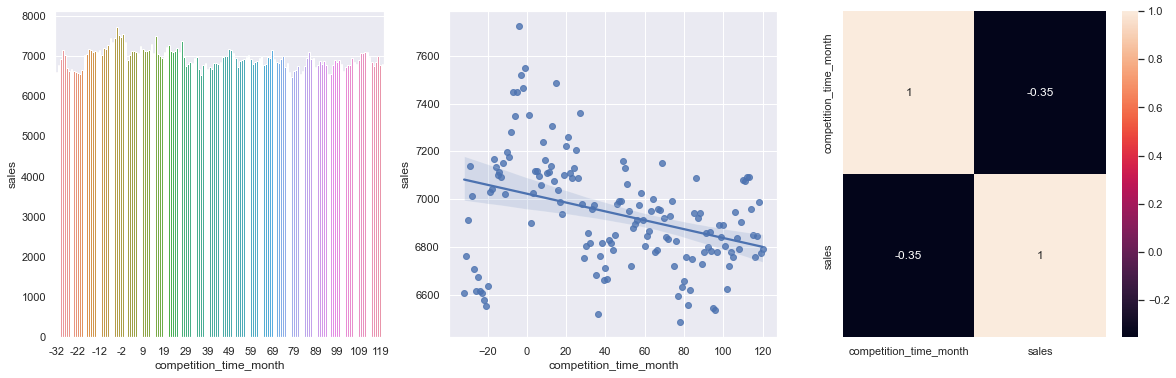

In [63]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
aux1 = df04[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
aux1 = aux1[(aux1['competition_time_month'] <= 120) &  (aux1['competition_time_month'] != 0)]
ax = sns.barplot(x='competition_time_month', y='sales', data=aux1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais
    
<b><font color='green'>VERDADEIRO</font> - Lojas como promocoes ativas por mais tempo vendem mais

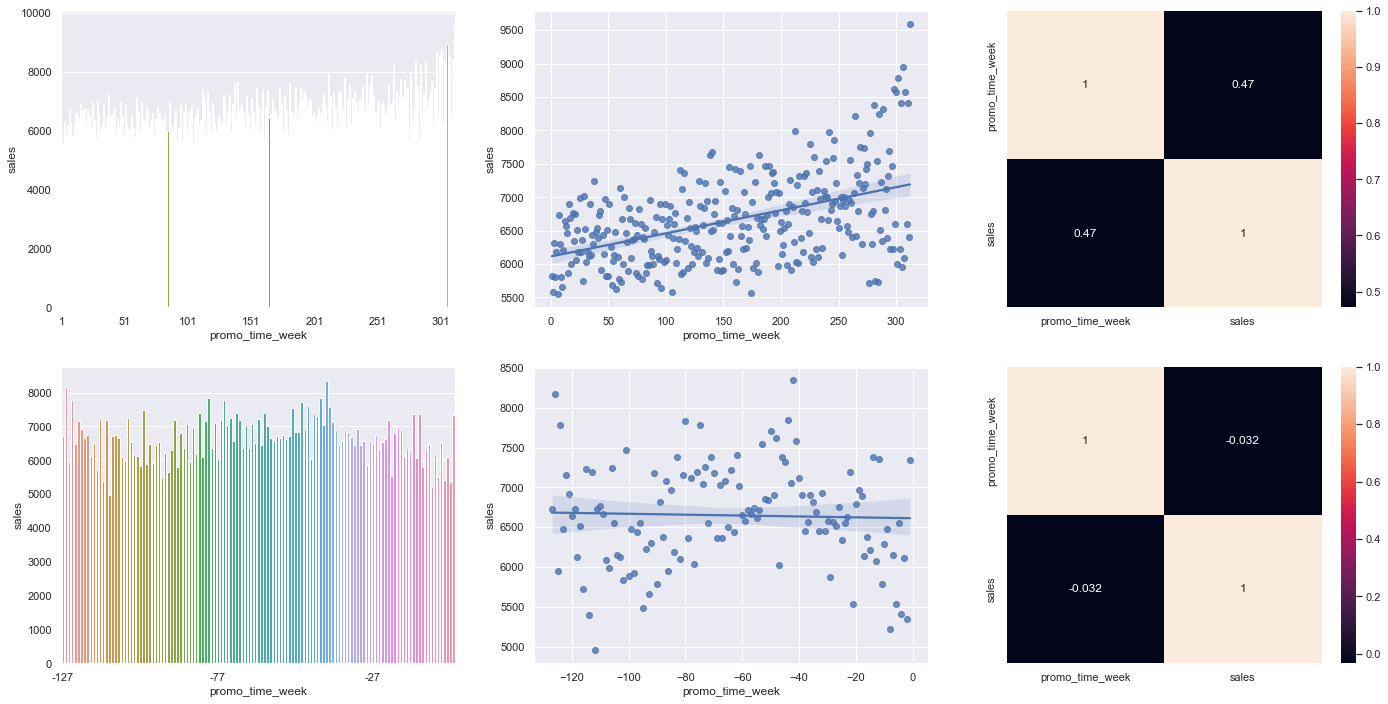

In [36]:
aux1 = df04[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0]  # extended promo
ax = sns.barplot(x='promo_time_week', y='sales', data=aux2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promo
ax2 = sns.barplot(x='promo_time_week', y='sales', data=aux3)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(50))

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[1,2])
sns.heatmap(aux3.corr(method='pearson'), annot=True);

plt.subplot(grid[0,2])
sns.heatmap(aux2.corr(method='pearson'), annot=True);


### H5. Lojas com mais dias de promoção deveriam vender mais
    
<b><font color='yellow'>PROXIMO CICLO</font>


### H6. Lojas com mais promoções consecutivas deveriam vender mais
    
<b><font color='red'>FALSO</font> - Lojas com a pomoção extendida costumam vender menos em média

SUM


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


MEAN


,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


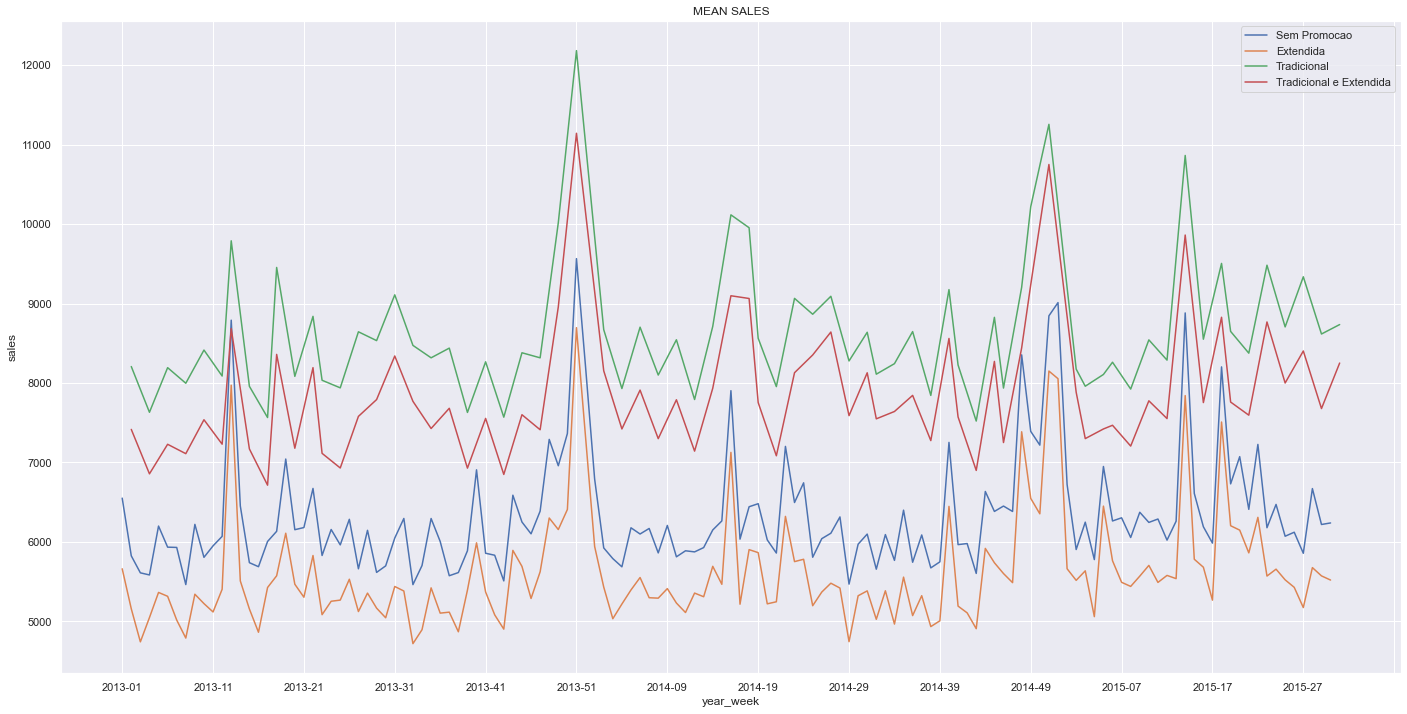

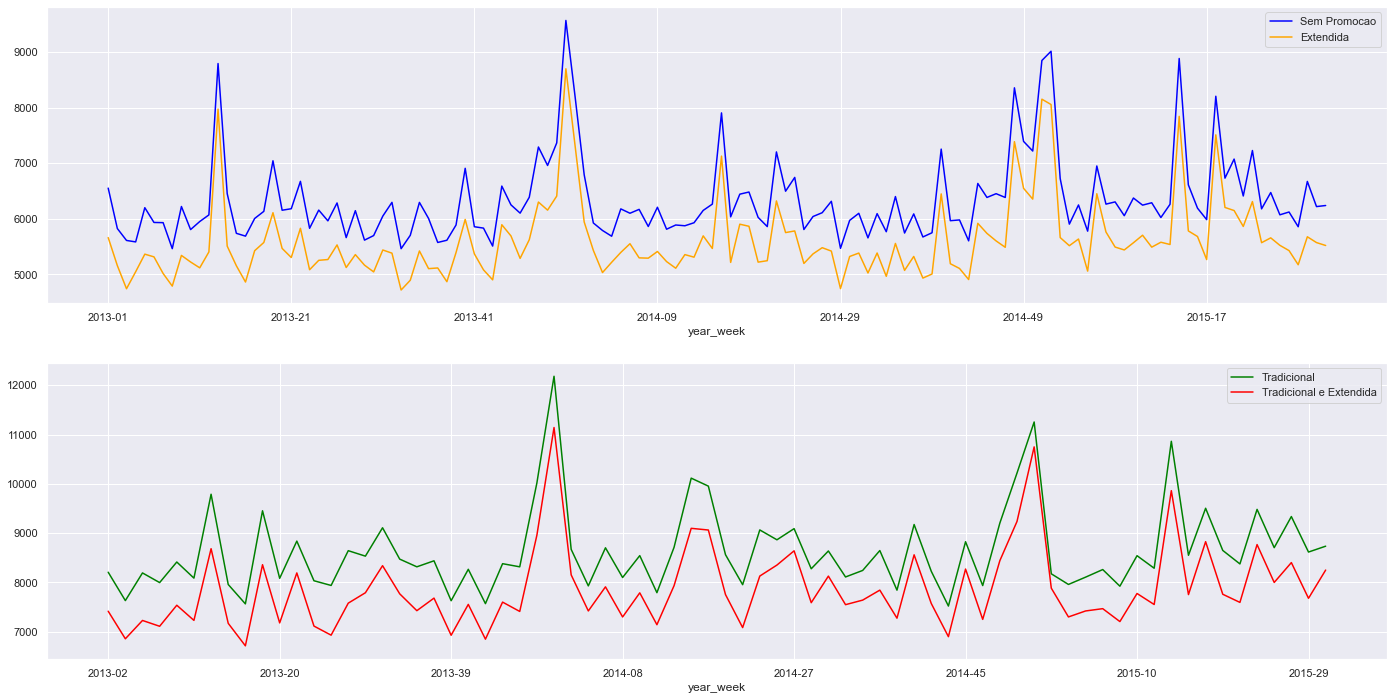

In [37]:
print('SUM')
display(df04[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index())
print('MEAN')
display(df04[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index())


aux1 = df04[['promo', 'promo2', 'sales', 'year_week']].groupby(['promo', 'promo2', 'year_week']).mean().reset_index()

aux1['both_promos'] = aux1['promo'].astype(str) + '-' + aux1['promo2'].astype(str)
ax = sns.lineplot(data=aux1, x="year_week", y="sales", hue="both_promos")
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

ax.legend(labels=['Sem Promocao', 'Extendida', 'Tradicional', 'Tradicional e Extendida'])
ax.set_title('MEAN SALES')
plt.show()



grid= GridSpec(2,2)
# first two type promos plot
plt.subplot(grid[0,:])
aux2 = aux1[(aux1['promo'] == 0) & (aux1['promo2'] == 0)].set_index('year_week')['sales']
ax2 = aux2.plot(color='blue')

aux3 = aux1[(aux1['promo'] == 0) & (aux1['promo2'] == 1)].set_index('year_week')['sales']
aux3.plot(ax=ax2, color='orange')

ax2.legend(labels=['Sem Promocao', 'Extendida'])


# last two type promos plot
plt.subplot(grid[1,:])
aux4 = aux1[(aux1['promo'] == 1) & (aux1['promo2'] == 0)].set_index('year_week')['sales']
ax3 = aux4.plot(color='green')

aux5 = aux1[(aux1['promo'] == 1) & (aux1['promo2'] == 1)].set_index('year_week')['sales']
aux5.plot(ax=ax3, color='red')

ax3.legend(labels=['Tradicional', 'Tradicional e Extendida'])
plt.show()

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais
    
<b><font color='green'>VERDADEIRO</font> - Lojas abertas no feriado do natal vendem mais que a média de outros dias, exceto a pascoa


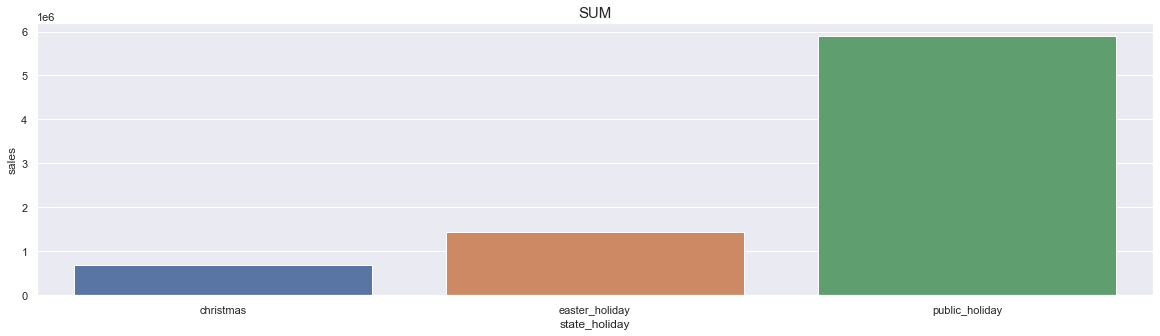

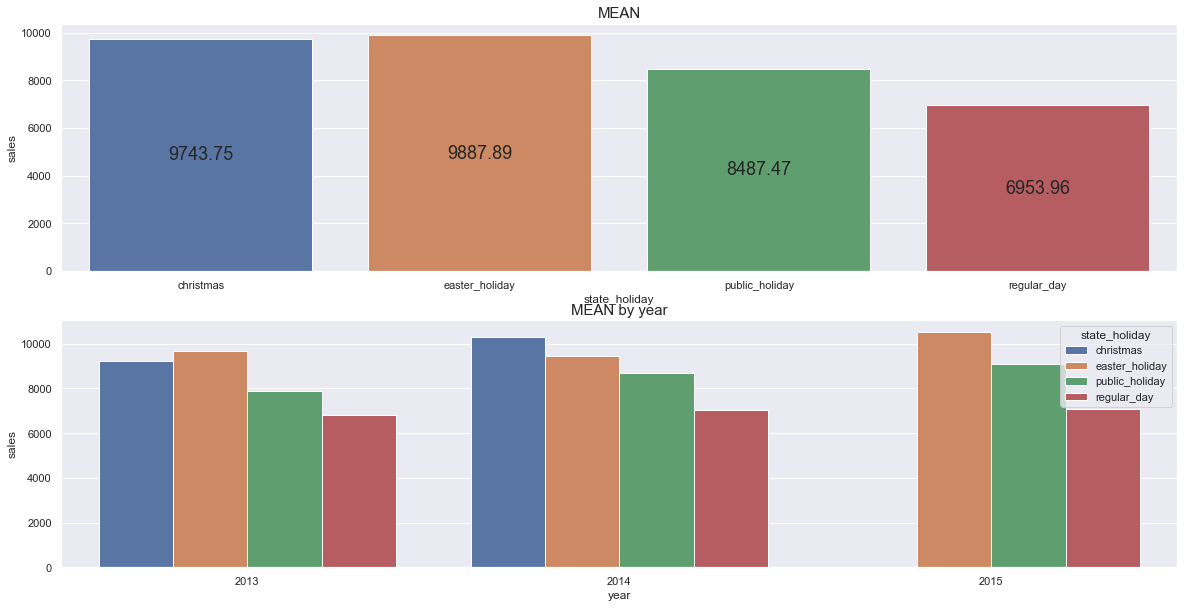

In [64]:
group_h7 = df04[['state_holiday','sales']].groupby('state_holiday')

plt.figure(figsize=(20,5))
aux2 = group_h7.sum().reset_index()
aux2 =  aux2[aux2['state_holiday'] != 'regular_day']
ax = sns.barplot(x='state_holiday', y='sales', data=aux2)
ax.set_title('SUM', fontsize=15)
plt.show()

#ranks = aux1['sales'].sort_values().index
#palette = sns.color_palette('Greens_d', len(ranks))
plt.subplot(2,1,1)
ax1 = sns.barplot(x='state_holiday', y='sales', data=group_h7.mean().reset_index())
ax1.bar_label(ax1.containers[0], label_type='center', fontsize=18)
ax1.set_title('MEAN', fontsize=15)

plt.subplot(2,1,2)
aux3 = df04[['year', 'state_holiday','sales']].groupby(['year', 'state_holiday']).mean().reset_index()
ax2 = sns.barplot(x='year', y='sales', hue='state_holiday', data=aux3)
ax2.set_title('MEAN by year', fontsize=15)

plt.show()

### H8. Lojas deveriam vender mais ao longo dos anos
    
<b><font color='red'>FALSO</font> - Lojas vendem menos ao longo dos anos


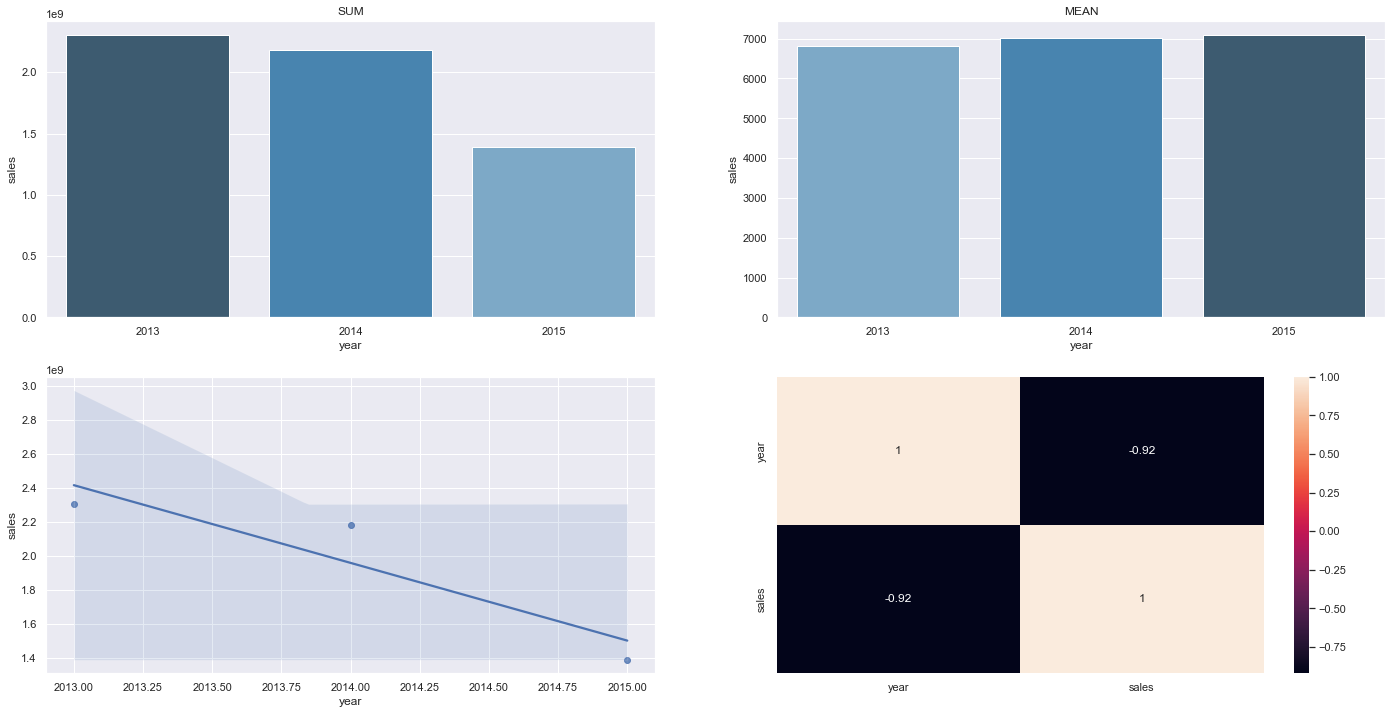

In [39]:
group_h8 = df04[['year','sales']].groupby('year')
sum_group = group_h8.sum().reset_index()
mean_group = group_h8.mean().reset_index()

plt.subplot(2,2,1)
ranks = mean_group['sales'].sort_values().index
palette = sns.color_palette('Blues_d', len(ranks))
sns.barplot(x='year', y='sales', data=sum_group, palette=np.array(palette[::-1])[ranks]).set_title('SUM')

plt.subplot(2,2,2)
ranks = mean_group['sales'].sort_values().index
palette = sns.color_palette('Blues_d', len(ranks))
sns.barplot(x='year', y='sales', data=mean_group, palette=np.array(palette)[ranks]).set_title('MEAN')

plt.subplot(2,2,3)
sns.regplot(x='year', y='sales', data=sum_group);
            
plt.subplot(2,2,4)
sns.heatmap(sum_group.corr(method='pearson'), annot=True);

### H9. Lojas deveriam vender mais no segundo semestre do ano
    
<b><font color='green'>VERDADEIRO</font> - Lojas vendem mais do segundo semestre do ano, principalmente devido a dezembro


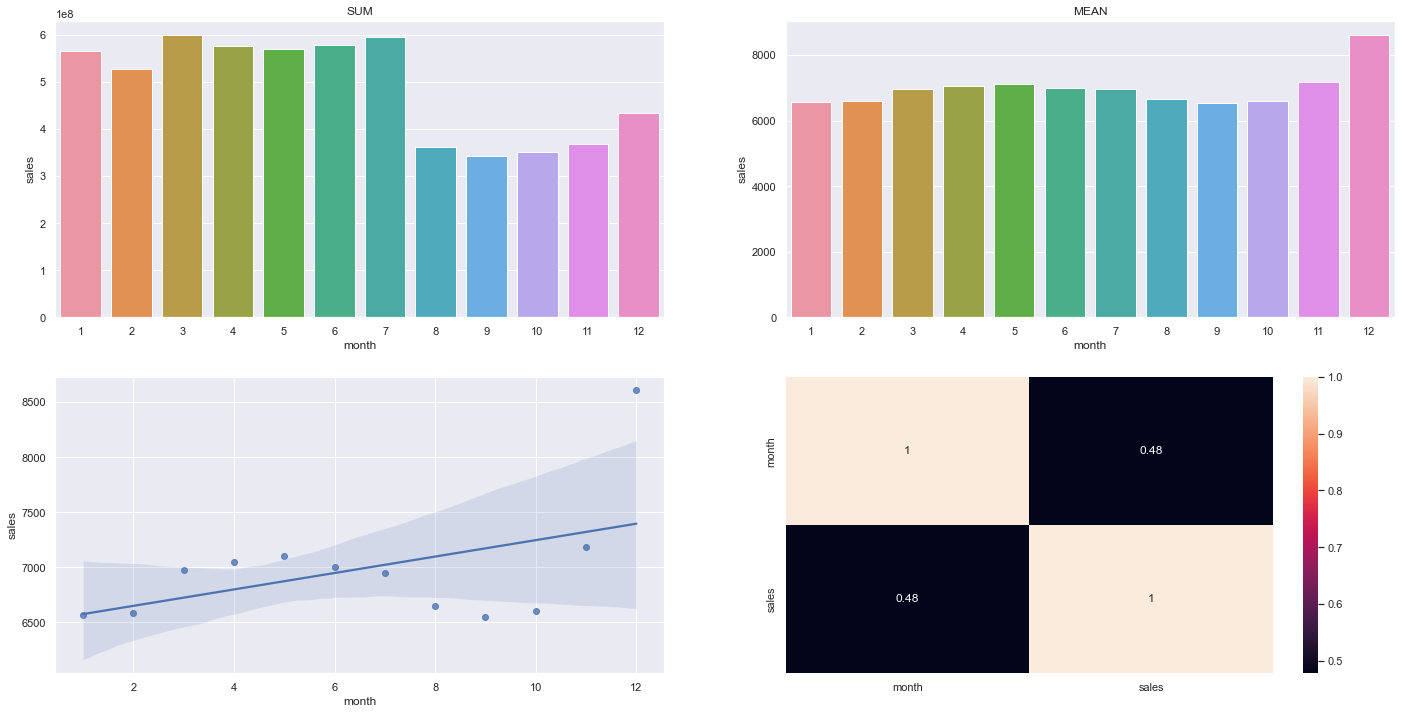

In [40]:
group_h8 = df04[['month','sales']].groupby('month')
sum_group = group_h8.sum().reset_index()
mean_group = group_h8.mean().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='month', y='sales', data=sum_group).set_title('SUM')

plt.subplot(2,2,2)
sns.barplot(x='month', y='sales', data=mean_group).set_title('MEAN')

plt.subplot(2,2,3)
sns.regplot(x='month', y='sales', data=mean_group);
            
plt.subplot(2,2,4)
sns.heatmap(mean_group.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês
    
<b><font color='red'>FALSO</font> - Lojas vendem, em média, mais nos primeiros 10 dias de cada mês


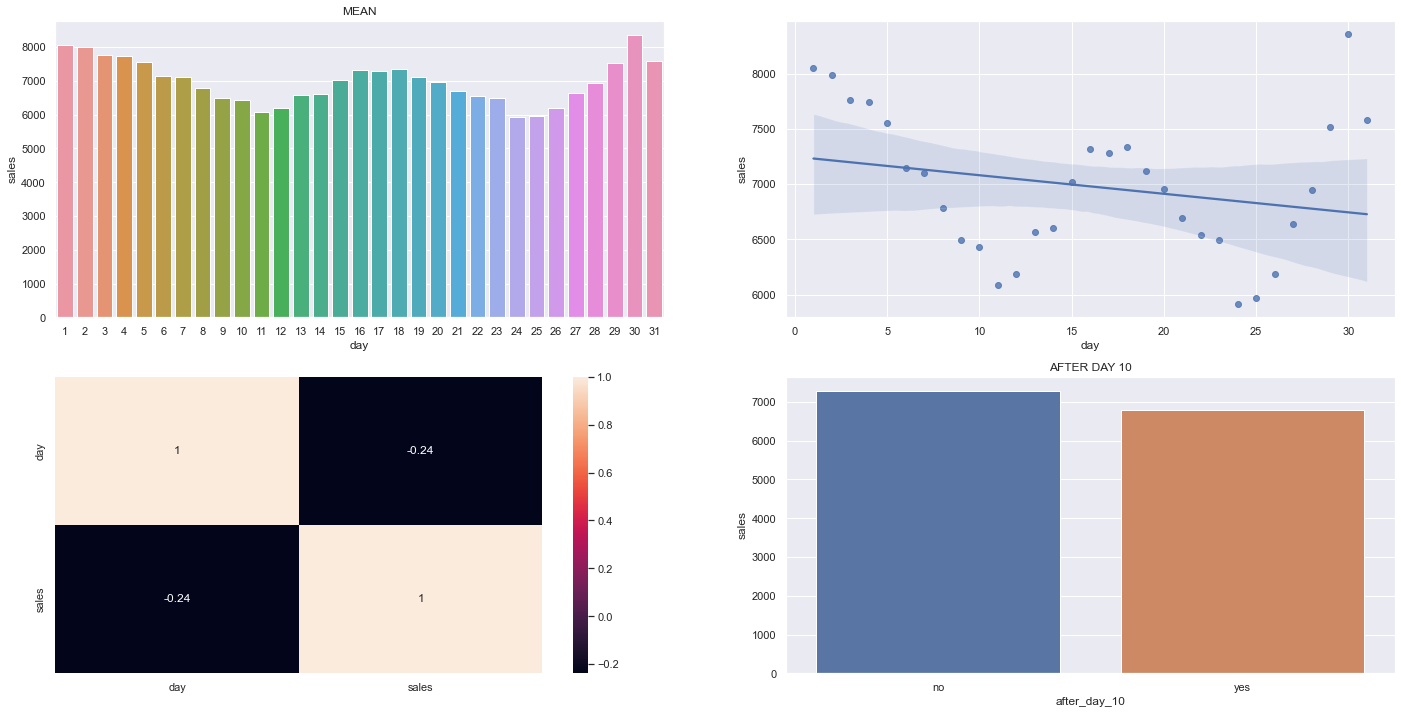

In [41]:
aux1 = df04[['day','sales']].groupby('day').mean().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1).set_title('MEAN')

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);
            
plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


plt.subplot(2,2,4)
aux2 = df04.copy()
aux2 = aux2[['day','sales']]

aux2['after_day_10'] = 'no'
aux2.loc[aux2['day']>10, 'after_day_10'] = 'yes'

aux2 = aux2.groupby('after_day_10').mean().reset_index()
sns.barplot(x='after_day_10', y='sales', data=aux2).set_title('AFTER DAY 10');

### H11. Lojas deveriam vender menos aos finais de semana
    
<b><font color='green'>VERDADEIRO</font> - Lojas vendem menos no final de semana, apesar de domingo possuir a maior média entre os dias da semana --> As lojas que abrem ao domingo possuem média alta


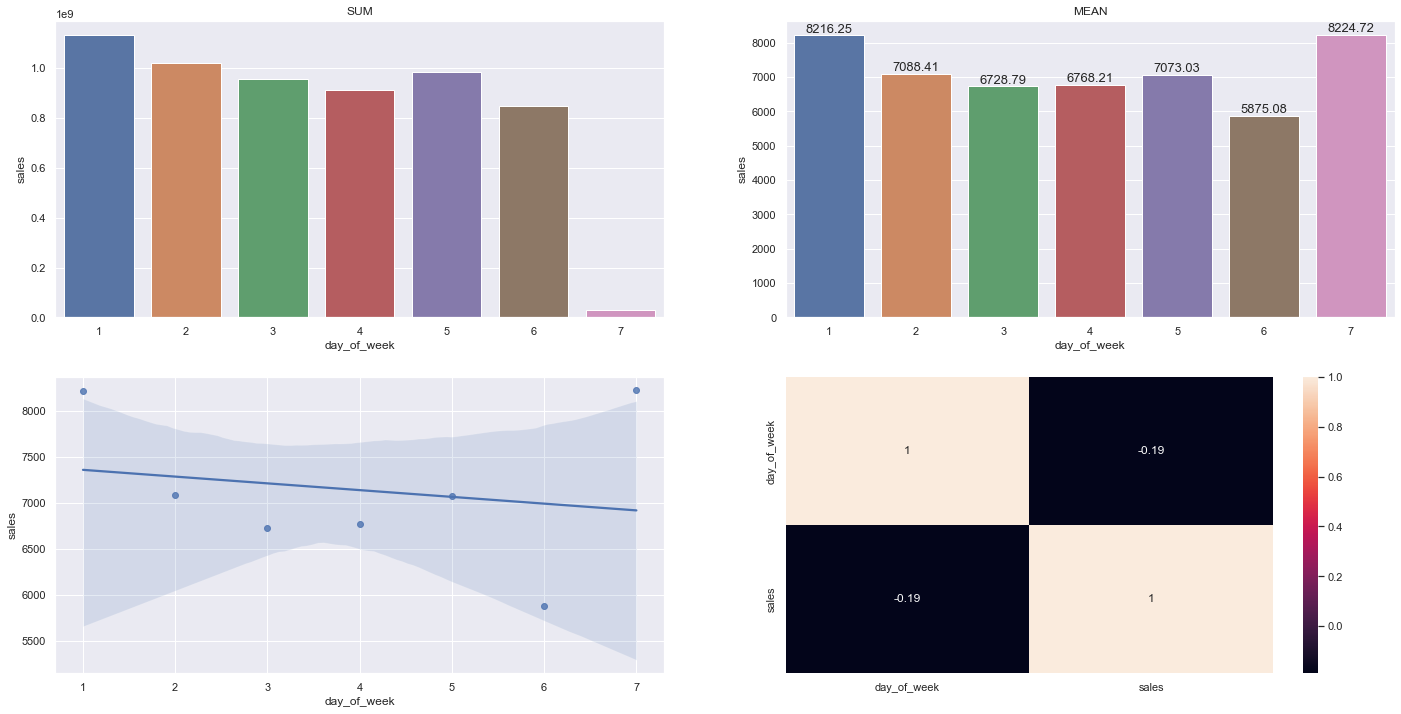

In [42]:
group_h8 = df04[['day_of_week','sales']].groupby('day_of_week')
sum_group = group_h8.sum().reset_index()
mean_group = group_h8.mean().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day_of_week', y='sales', data=sum_group).set_title('SUM')

plt.subplot(2,2,2)
ax = sns.barplot(x='day_of_week', y='sales', data=mean_group)
ax.bar_label(ax.containers[0], label_type='edge', fontsize=13)
ax.set_title('MEAN')

plt.subplot(2,2,3)
sns.regplot(x='day_of_week', y='sales', data=mean_group);
            
plt.subplot(2,2,4)
sns.heatmap(mean_group.corr(method='pearson'), annot=True);

- A média de vendas no domingo aparentar ser boa, porém quando filtrado apenas lojas que abrem no domingo é possível visualizar que essas lojas têm uma média bem mais alta. Com isso, o final de semana realmente vende menos.

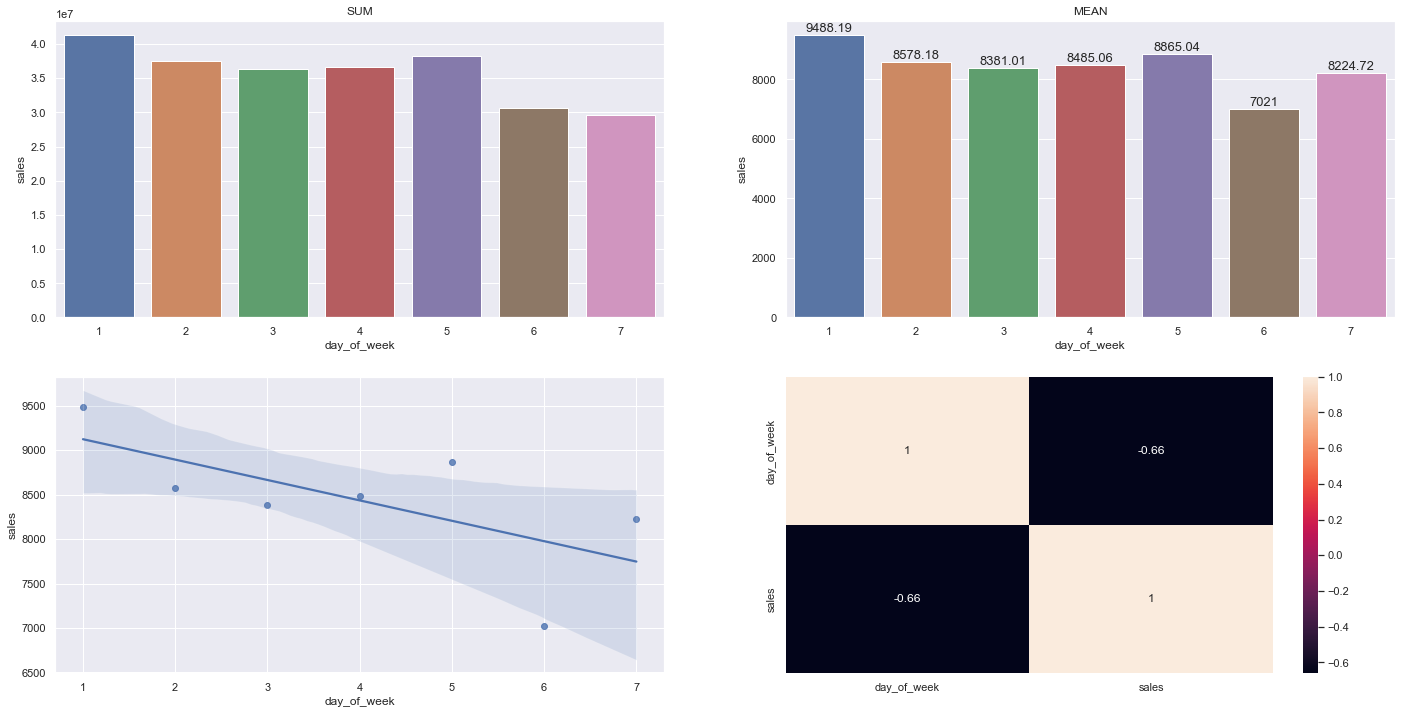

In [47]:
store_open_sunday = list(df04[df04['day_of_week'] == 7]['store'].unique())
open_sunday = df04.loc[df04['store'].isin(store_open_sunday)]

group_h8 = open_sunday[['day_of_week','sales']].groupby('day_of_week')
sum_group = group_h8.sum().reset_index()
mean_group = group_h8.mean().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day_of_week', y='sales', data=sum_group).set_title('SUM')

plt.subplot(2,2,2)
ax = sns.barplot(x='day_of_week', y='sales', data=mean_group)
ax.bar_label(ax.containers[0], label_type='edge', fontsize=13)
ax.set_title('MEAN')

plt.subplot(2,2,3)
sns.regplot(x='day_of_week', y='sales', data=mean_group);
            
plt.subplot(2,2,4)
sns.heatmap(mean_group.corr(method='pearson'), annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares
    
<b><font color='red'>FALSO</font> - Lojas vendem mais durante os feriados escolares


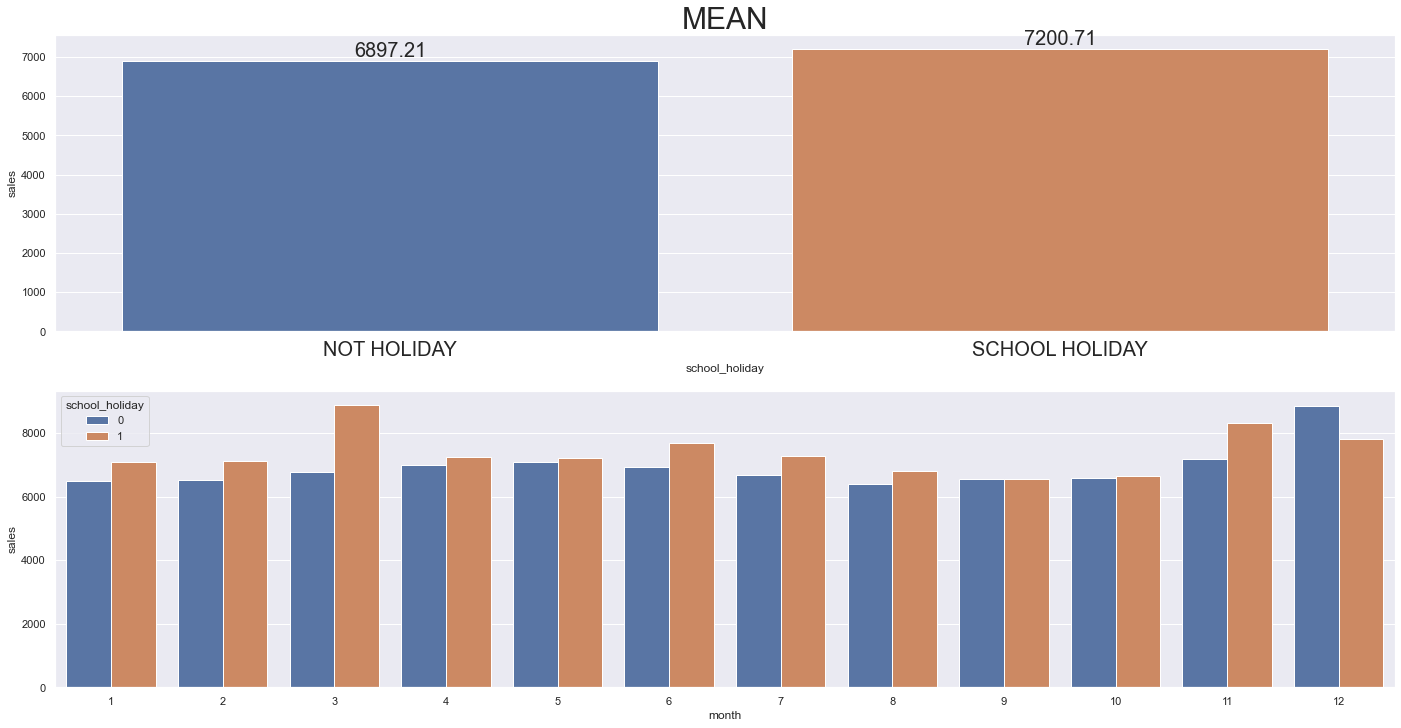

In [44]:

plt.subplot(2,1,1)
aux1 = df04[['school_holiday','sales']].groupby('school_holiday').mean().reset_index()

ax = sns.barplot(x='school_holiday', y='sales', data=aux1)
ax.bar_label(ax.containers[0], label_type='edge', fontsize=20)
ax.set_title('MEAN', fontsize=30)

ax.set_xticks([0,1],labels=['NOT HOLIDAY', 'SCHOOL HOLIDAY'], fontsize=20)

plt.subplot(2,1,2)
aux2 = df04[['month', 'school_holiday','sales']].groupby(['school_holiday', 'month']).mean().reset_index()

ax = sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)
#ax.bar_label(ax.containers[0], label_type='edge', fontsize=10)

plt.show()

### 4.2.1. Resumo das Hipoteses

In [45]:
r = [['H1', 'Verdadeira', 'Alta'],
 ['H2', 'Falsa', 'Baixa'],
 ['H3', 'Falsa', 'Media'],
 ['H4', 'Verdadeira', 'Media'],
 ['H5', '-', '-'],
 ['H6', 'Falsa', 'Alta'],
 ['H7', 'Verdadeira', 'Baixa'],
 ['H8', 'Falsa', 'Baixa'],
 ['H9', 'Verdadeira', 'Media'],
 ['H10', 'Falsa', 'Media'],
 ['H11', 'Verdadeira', 'Alta'],
 ['H12', 'Falsa', 'Media']]

resume_hip = pd.DataFrame(data=r, columns=['Hipotese', 'Conclusao', 'Relevancia'])
display(resume_hip)

,Hipotese,Conclusao,Relevancia
0,H1,Verdadeira,Alta
1,H2,Falsa,Baixa
2,H3,Falsa,Media
3,H4,Verdadeira,Media
4,H5,-,-
5,H6,Falsa,Alta
6,H7,Verdadeira,Baixa
7,H8,Falsa,Baixa
8,H9,Verdadeira,Media
9,H10,Falsa,Media


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

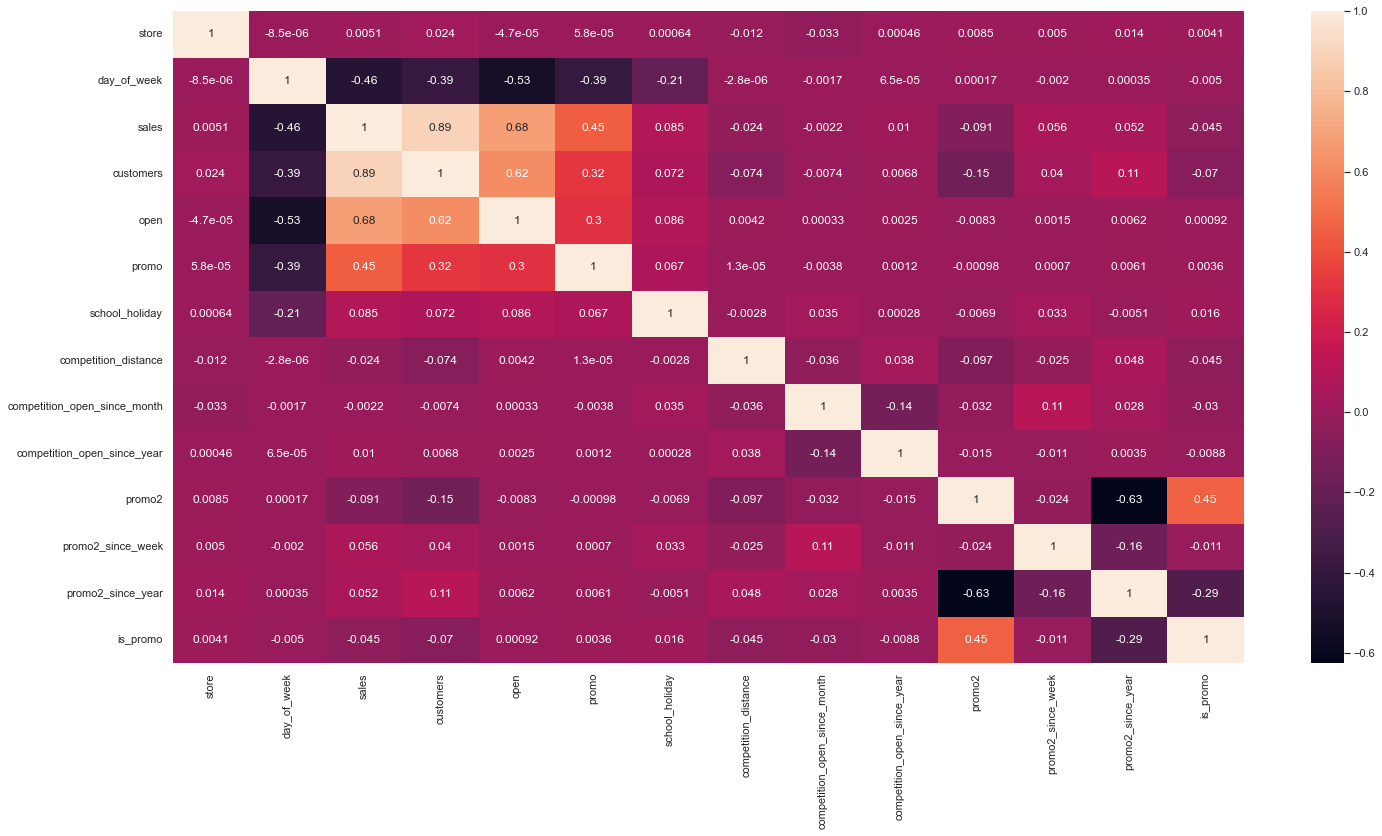

In [46]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Attributes

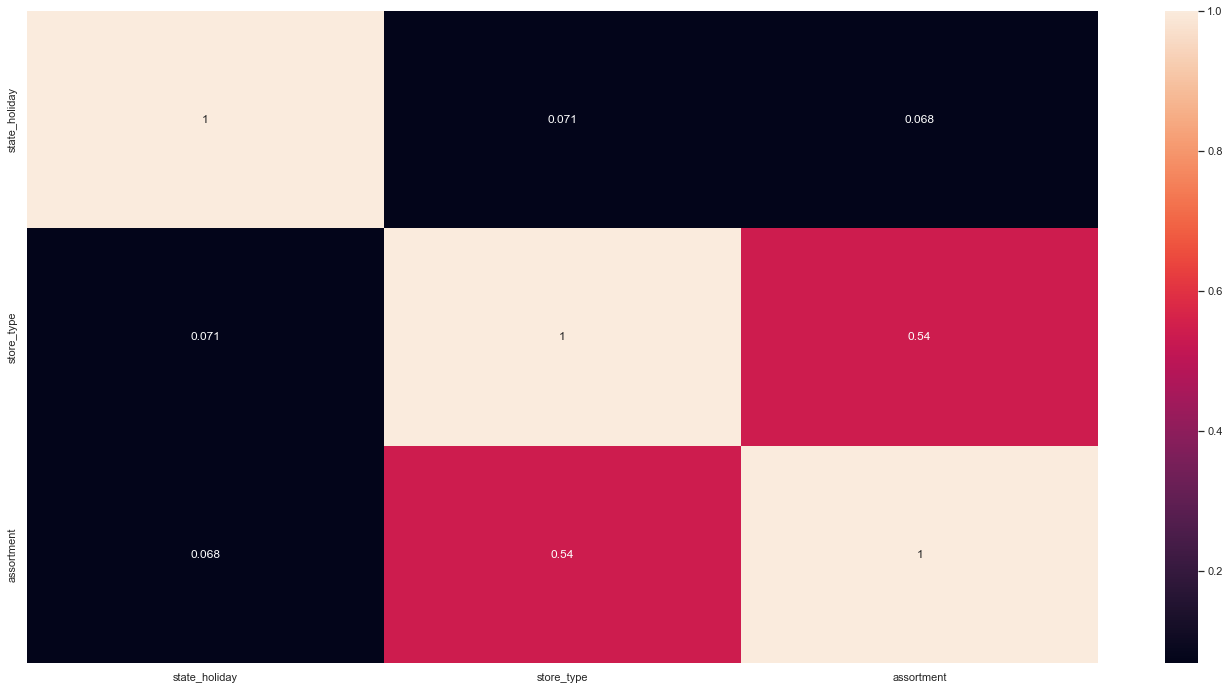

In [47]:
# categorical data
a = df04.select_dtypes(include='object')

# cramer v 
a1 = cramer_v( a['state_holiday'], a['state_holiday'])
a2 = cramer_v( a['state_holiday'], a['store_type'])
a3 = cramer_v( a['state_holiday'], a['assortment'])

a4 = cramer_v( a['store_type'], a['state_holiday'])
a5 = cramer_v( a['store_type'], a['store_type'])
a6 = cramer_v( a['store_type'], a['assortment'])

a7 = cramer_v( a['assortment'], a['state_holiday'])
a8 = cramer_v( a['assortment'], a['store_type'])
a9 = cramer_v( a['assortment'], a['assortment'])

# creating dataframe
d = pd.DataFrame({'state_holiday':[a1, a2, a3],
              'store_type':[a4, a5, a6],
              'assortment':[a7, a8, a9]})
d = d.set_index(d.columns)

# plot
sns.heatmap(d, annot=True);

# 5.0. PASSO 05 - PREPARAÇAO DOS DADOS

In [51]:
df04 = pd.read_pickle('../../data/intermediary_data_df04.pkl')
df05 = df04.drop(columns=['promo_since','competition_since','year_week']).copy()

## 5.1. Nature Transformation

In [52]:
########### Response Variable Transformation ###########
        
# sales --> Logarithm Transformation
df05['sales'] = np.log1p(df05['sales'])

########### Nature Transformation ###########

# day_of_week
len_day_of_week = 7
df05['day_of_week_sin'] = df05['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/len_day_of_week)))
df05['day_of_week_cos'] = df05['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/len_day_of_week)))

# month
len_month = 12
df05['month_sin'] = df05['month'].apply(lambda x: np.sin(x*(2*np.pi/len_month)))
df05['month_cos'] = df05['month'].apply(lambda x: np.cos(x*(2*np.pi/len_month)))

# day
len_day = 31
df05['day_sin'] = df05['day'].apply(lambda x: np.sin(x*(2*np.pi/len_day)))
df05['day_cos'] = df05['day'].apply(lambda x: np.cos(x*(2*np.pi/len_day)))

# week_of_year
len_week_of_year = 52
df05['week_of_year_sin'] = df05['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/len_week_of_year)))
df05['week_of_year_cos'] = df05['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/len_week_of_year)))

df05 = df05.drop(columns=['day_of_week', 'month', 'day', 'week_of_year'])

## 5.2. Split in Train and Test

In [53]:
max_date = df05[['store', 'date']].groupby('store').max()['date'].max()
first_date = max_date - datetime.timedelta(weeks=6)
print(f"Test DataSet --> {first_date.strftime(format='%Y-%m-%d')} to {max_date.strftime(format='%Y-%m-%d')}")

Test DataSet --> 2015-06-19 to 2015-07-31


In [54]:
# train dataset
X_train = df05[df05['date']<'2015-06-19']

# test dataset
X_test= df05[df05['date']>='2015-06-19']

print(f"Training Min Date: {X_train['date'].min()}")
print(f"Training Max Date: {X_train['date'].max()}")

print(f"Test Min Date: {X_test['date'].min()}")
print(f"Test Max Date: {X_test['date'].max()}")

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00
Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 5.3. Preparation => Normalization - Rescaling - Encoding

### 5.3.1. Class

In [55]:
class DataPrepatarion:
    def __init__(self, dataframe):
        self.data = dataframe.copy() 
        self.normalization()
        self.rescaling()
        self.encoding()

        
    def normalization(self):
        pass
    
    
    def rescaling(self):
        
        # minmax --> when has less outliers
        # robust scaler --> when has more outliers
        
        # competition_distance --> outliers
        self.rs_competition_distance = RobustScaler()
        self.data['competition_distance'] = self.rs_competition_distance.fit_transform(self.data[['competition_distance']].values)

        # competition_time_month
        self.rs_competition_time_month = RobustScaler()
        self.data['competition_time_month'] = self.rs_competition_time_month.fit_transform(self.data[['competition_time_month']].values)
        
        # year
        self.minmax_year = MinMaxScaler()
        self.data['year'] = self.minmax_year.fit_transform(self.data[['year']].values)

        # promo_time_week
        self.minmax_promo_time_week = MinMaxScaler()
        self.data['promo_time_week'] = self.minmax_promo_time_week.fit_transform(self.data[['promo_time_week']].values)

        
    def encoding(self):
        
        #state_holiday - One Hot Encoding
        self.one_hot_state_holiday = OneHotEncoder(use_cat_names=True)
        state_holiday_encoded = self.one_hot_state_holiday.fit_transform(self.data['state_holiday'])
        columns_created = self.one_hot_state_holiday.get_feature_names()
        
        self.data[columns_created] =  state_holiday_encoded.values
        self.data = self.data.drop(columns=['state_holiday', columns_created[0]])
        

        #store_type - Label Encoding
        self.le_store_type = LabelEncoder()
        self.data['store_type'] = self.le_store_type.fit_transform(self.data['store_type'])
        
        #assortment- Ordinal Encoding
        assortment_dict = {'basic':1,
                           'extra':2,
                           'extended':3}
        self.data['assortment'] = self.data['assortment'].map(assortment_dict)
        
 
    def dump_transformers(self):
        
        # competition_distance
        pickle.dump(self.rs_competition_distance, open('../parameter/competition_distance_scaler.pkl', 'wb'))

        # competition_time_month
        pickle.dump(self.rs_competition_time_month, open('../parameter/competition_time_month_scaler.pkl', 'wb'))

        # year
        pickle.dump(self.minmax_year, open('../parameter/year_scaler.pkl', 'wb'))

        # promo_time_week
        pickle.dump(self.minmax_promo_time_week, open('../parameter/promo_time_week_scaler.pkl', 'wb'))
        
        #state_holiday - One Hot Encoding
        pickle.dump(self.one_hot_state_holiday, open('../parameter/state_holiday_encoded.pkl', 'wb'))
        
        #store_type - Label Encoding
        pickle.dump(self.le_store_type, open('../parameter/store_type_encoding.pkl', 'wb'))
    
    def get_train_data(self):
        return self.data.copy()
    
    
    def transform_a_data(self, data_test):
        '''PASS THE TEST OR VALIDATION DATA TO TRANSFORM'''
        
        data_to_transform = data_test.copy()
        
        
        # competition_distance --> outliers
        data_to_transform['competition_distance'] = self.rs_competition_distance.transform(data_to_transform[['competition_distance']].values)


        # competition_time_month
        data_to_transform['competition_time_month'] = self.rs_competition_time_month.transform(data_to_transform[['competition_time_month']].values)
        
        # year
        data_to_transform['year'] = self.minmax_year.transform(data_to_transform[['year']].values)

        # promo_time_week
        data_to_transform['promo_time_week'] = self.minmax_promo_time_week.transform(data_to_transform[['promo_time_week']].values)
        
        #state_holiday - One Hot Encoding
        state_holiday_encoded = self.one_hot_state_holiday.transform(data_to_transform['state_holiday'])
        columns_created = self.one_hot_state_holiday.get_feature_names()
        
        data_to_transform[columns_created] =  state_holiday_encoded.values
        data_to_transform = data_to_transform.drop(columns=['state_holiday', columns_created[0]])
        
        
        #store_type - Label Encoding
        data_to_transform['store_type'] = self.le_store_type.transform(data_to_transform['store_type'])
        
        #assortment- Ordinal Encoding
        assortment_dict = {'basic':1,
                           'extra':2,
                           'extended':3}
        data_to_transform['assortment'] = data_to_transform['assortment'].map(assortment_dict)
        
        
        return data_to_transform.copy()

### 5.3.2. Train Preparation

In [56]:
x_training_for_k_fold = X_train.copy()

my_data_preparation = DataPrepatarion(X_train)

# dump parameters
my_data_preparation.dump_transformers()

# return train data
X_train = my_data_preparation.get_train_data()

y_train = X_train['sales']

### 5.3.3. Test Preparation

In [57]:
X_test = my_data_preparation.transform_a_data(X_test)
y_test = X_test['sales']

# 6.0. PASSO 06 - FEATURE SELECTION

## 6.1. Boruta as feture selector

In [58]:
# # training and test dataset as vectors
# X_train_n = X_train.drop(columns=['date', 'sales']).values
# y_train_n = y_train.values.ravel()

# # define random forest
# rf = RandomForestRegressor(n_jobs=-1) # use all core's

# # define boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=99).fit(X_train_n, y_train_n)

### 6.1.1 Best features from boruta

In [59]:
# # best features
# cols_selected = boruta.support_.tolist()
# X_train_fs = X_train.drop(columns=['date', 'sales'])
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))
# print(cols_not_selected_boruta)

## 6.2. Manual Feature Selection

In [58]:
# cols selected by boruta
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

#plus month sin and week of year sin
cols_selected_boruta.extend(['month_sin', 'week_of_year_sin'])

In [59]:
# features_to_add = ['date', 'sales']
# cols_selected_boruta_full = cols_selected_boruta.copy()
# cols_selected_boruta_full.extend(features_to_add)

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [60]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1. Average Model

In [61]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = aux1.merge(aux2, on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_performance = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline)) 
baseline_performance

,MODEL_NAME,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model

In [62]:
# model
lr = LinearRegression()
lr.fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_performance = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr)) 
lr_performance

,MODEL_NAME,MAE,MAPE,RMSE
0,Linear Regression,1867.089787,0.292762,2671.374921


### 7.2.1. Linear Regression Model - Cross Validation

In [63]:
lr_result_cv = cross_validation( x_training_for_k_fold, 5, 'Linear Regression', lr, cols_selected_boruta, verbose=False)
lr_result_cv

,MODEL_NAME,MAE,MAPE,RMSE
0,Linear Regression,2081.43 +/- 330.5,0.3 +/- 0.02,2952.61 +/- 523.35


## 7.3. Linear Regression Regularized Model - Lasso

In [102]:
# model
lrr = Lasso(alpha=0.01) # fator mutiplicativo --> todos os pesos ficarem dentro de um range
lrr.fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_performance = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr)) 
lrr_performance

,MODEL_NAME,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.205739,0.289296,2743.001978


### 7.3.1. Lasso - Cross Validation

In [95]:
lrr_result_cv = cross_validation( x_training_for_k_fold, 5, 'Lasso', lrr, cols_selected_boruta, verbose=False)
lrr_result_cv

,MODEL_NAME,MAE,MAPE,RMSE
0,Lasso,2115.81 +/- 381.63,0.29 +/- 0.01,3057.22 +/- 563.11


## 7.4. Random Forest

In [103]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=99)
rf.fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_performance = ml_error('Random Forest', np.expm1(y_test), np.expm1(yhat_rf)) 
rf_performance

,MODEL_NAME,MAE,MAPE,RMSE
0,Random Forest,685.789625,0.101096,1018.897781


### 7.4.1. Random Forest - Cross Validation

In [97]:
rf_result_cv = cross_validation( x_training_for_k_fold, 5, 'Random Forest', rf, cols_selected_boruta, verbose=True)
rf_result_cv

KFold Number: 5 of Random Forest
KFold Number: 4 of Random Forest
KFold Number: 3 of Random Forest
KFold Number: 2 of Random Forest
KFold Number: 1 of Random Forest
      MODEL_NAME          MAE      MAPE         RMSE
0  Random Forest  1301.592794  0.161300  1992.789185
0  Random Forest   911.197313  0.140624  1363.455250
0  Random Forest   555.515011  0.089246   863.271244
0  Random Forest   850.295977  0.109090  1290.513311
0  Random Forest   702.745169  0.097859  1016.637391


,MODEL_NAME,MAE,MAPE,RMSE
0,Random Forest,864.27 +/- 280.65,0.12 +/- 0.03,1305.33 +/- 434.44


## 7.5. XGBoost Regressor

In [21]:
# model
model_xgb = xgb.XGBRegressor().fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_performance = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb)) 
xgb_performance

,MODEL_NAME,MAE,MAPE,RMSE
0,XGBoost Regressor,871.412039,0.129831,1260.128054


### 7.5.1. XGBoost Regressor - Cross Validation

In [43]:
xgb_result_cv = cross_validation( x_training_for_k_fold, 5, 'XGBoost Regressor', model_xgb, cols_selected_boruta, verbose=True)
xgb_result_cv

KFold Number: 5 of XGBoost Regressor
KFold Number: 4 of XGBoost Regressor
KFold Number: 3 of XGBoost Regressor
KFold Number: 2 of XGBoost Regressor
KFold Number: 1 of XGBoost Regressor


          MODEL_NAME          MAE      MAPE         RMSE
0  XGBoost Regressor  1353.568524  0.173544  1957.444190
0  XGBoost Regressor  1120.630788  0.163354  1595.750103
0  XGBoost Regressor   901.578527  0.137039  1312.280919
0  XGBoost Regressor  1104.881893  0.144183  1624.069635
0  XGBoost Regressor   976.137143  0.135522  1390.096260




,MODEL_NAME,MAE,MAPE,RMSE
0,XGBoost Regressor,1091.36 +/- 172.54,0.15 +/- 0.02,1575.93 +/- 251.15


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [101]:
models_performance = pd.concat([baseline_performance, lr_performance, 
                               lrr_performance, rf_performance, xgb_performance])
models_performance.sort_values('RMSE')

,MODEL_NAME,MAE,MAPE,RMSE
0,Random Forest,685.789625,0.101096,1018.897781
0,XGBoost Regressor,871.412039,0.129831,1260.128054
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089787,0.292762,2671.374921
0,Linear Regression - Lasso,1891.205739,0.289296,2743.001978


### 7.6.1. Real Performance - Cross Validation

In [102]:
models_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
models_result_cv

,MODEL_NAME,MAE,MAPE,RMSE
0,Linea Regression,2081.43 +/- 330.5,0.3 +/- 0.02,2952.61 +/- 523.35
0,Lasso,2115.81 +/- 381.63,0.29 +/- 0.01,3057.22 +/- 563.11
0,Random Forest,864.27 +/- 280.65,0.12 +/- 0.03,1305.33 +/- 434.44
0,XGBoost Regressor,1091.4 +/- 172.52,0.15 +/- 0.02,1575.97 +/- 251.12


# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [ ]:
# param = {
#     'n_estimators': [800, 1300, 2100],
#     'learning_rate': [0.03, 0.05, 0.08], 
#     'max_depth': [3, 6, 9],
#     'subsample': [0.5, 0.75, 1],  
#     'colsample_bytee': [0.5, 0.75, 1],
#     'colsample_bynode': [0.5, 0.75, 1],
#     'min_child_weight': [1, 3, 5]
# }

# MAX_EVAL = 5

In [ ]:
# final_result_ft = pd.DataFrame()

# for i in range(MAX_EVAL):
#     # choose values for parameteres randomly
#     hp = {key: random.sample(value,1)[0] for key, value in param.items()}
#     print(hp)
#     # model
#     model_xgb_ft = xgb.XGBRegressor(
#          learning_rate=hp['learning_rate'],
#          n_estimators=hp['n_estimators'],
#          max_depth=hp['max_depth'],
#          min_child_weight=hp['min_child_weight'],
#          subsample=hp['subsample'],
#          colsample_bynode=hp['colsample_bynode'],
#          colsample_bytee=hp['colsample_bytee'],
#          booster="gbtree",
#          objective='reg:squarederror')

#     # result
#     xgb_result = cross_validation( x_training_for_k_fold, 5, 'XGBoost Regressor', model_xgb_ft, verbose=True)
#     final_result_ft = pd.concat([final_result_ft, xgb_result])

## 8.2. Final Model

### 8.2.1. By random search (upgraded)

In [73]:
# # OBS --> colsample_bytee warning might not be used --> tested without --> no changes
# # OBS --> tested min_child_weight = 1 --> worst than 5

# param_tuned = {
#     'n_estimators': 1300,
#     'learning_rate': 0.11, 
#     'max_depth': 12,
#     'subsample': 0.5,  
#     'colsample_bynode': 0.5,
#     'min_child_weight': 5
# }

### 8.2.2. Just by tests

In [103]:
param_tuned = {
    'n_estimators': 1300,
    'learning_rate': 0.08, 
    'max_depth': 6,
    'subsample': 0.5,  
    'colsample_bynode': 0.5,
    'min_child_weight': 1
}

Escolhido o por teste, pois, apesar de ter um erro um pouco maior, ocupa apenas 9mb de espaço x 260 mb do outro modelo

In [104]:
# model
model_xgb_tuned = xgb.XGBRegressor(
         learning_rate=param_tuned['learning_rate'],
         n_estimators=param_tuned['n_estimators'],
         max_depth=param_tuned['max_depth'],
         min_child_weight=param_tuned['min_child_weight'],
         subsample=param_tuned['subsample'],
         colsample_bynode=param_tuned['colsample_bynode'],
         booster="gbtree",
         objective='reg:squarederror').fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_performance_tuned = ml_error('XGBoost Regressor', np.expm1(y_test),
                           np.expm1(yhat_xgb_tuned))
xgb_performance_tuned

,MODEL_NAME,MAE,MAPE,RMSE
0,XGBoost Regressor,676.81655,0.100198,978.865394


# 9.0. PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO

In [105]:
df09 = X_test[cols_selected_boruta_full]

# rescale 
df09['sales'] = np.expm1(df09['sales'])
df09['predictions'] = np.expm1(yhat_xgb_tuned)

C:\Users\Miguel\AppData\Local\Temp/ipykernel_8732/1258380783.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df09['sales'] = np.expm1(df09['sales'])
C:\Users\Miguel\AppData\Local\Temp/ipykernel_8732/1258380783.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df09['predictions'] = np.expm1(yhat_xgb_tuned)


## 9.1. Business Performance

In [106]:
# sum of predictions
df09_sums = df09[['store', 'predictions', 'sales']].groupby('store').sum().reset_index()

# MAE e MAPE
df09_aux1 = df09[['store', 'sales', 'predictions']].groupby('store').apply(
    lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})

df09_aux2 = df09[['store', 'sales', 'predictions']].groupby('store').apply(
    lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df09_aux3 = df09_aux1.merge(df09_aux2, on='store')
df09_bp = df09_sums.merge(df09_aux3, on='store')

# Scenarios
df09_bp['worst_scenario'] = df09_bp['predictions'] - (df09_bp['predictions'] * df09_bp['MAPE'])
df09_bp['best_scenario'] = df09_bp['predictions'] + (df09_bp['predictions'] * df09_bp['MAPE'])

df09_bp['worst_scenario'].apply(lambda x: x if x >= 0 else 0)

# order columns
df09_bp = df09_bp[['store', 'sales','predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

df09_bp.sample(5)

,store,sales,predictions,worst_scenario,best_scenario,MAE,MAPE
810,811,154823.0,148814.328125,137912.842943,159715.813307,302.385063,0.073256
922,923,197417.0,197190.984375,180579.781842,213802.186908,453.853714,0.084239
105,106,332521.0,303013.843750,273576.649237,332451.038263,920.736447,0.097148
259,260,232558.0,229997.468750,208854.933209,251140.004291,583.007311,0.091925
556,557,148642.0,160882.593750,138283.774310,183481.413190,500.425227,0.140468


<AxesSubplot:xlabel='store', ylabel='MAPE'>

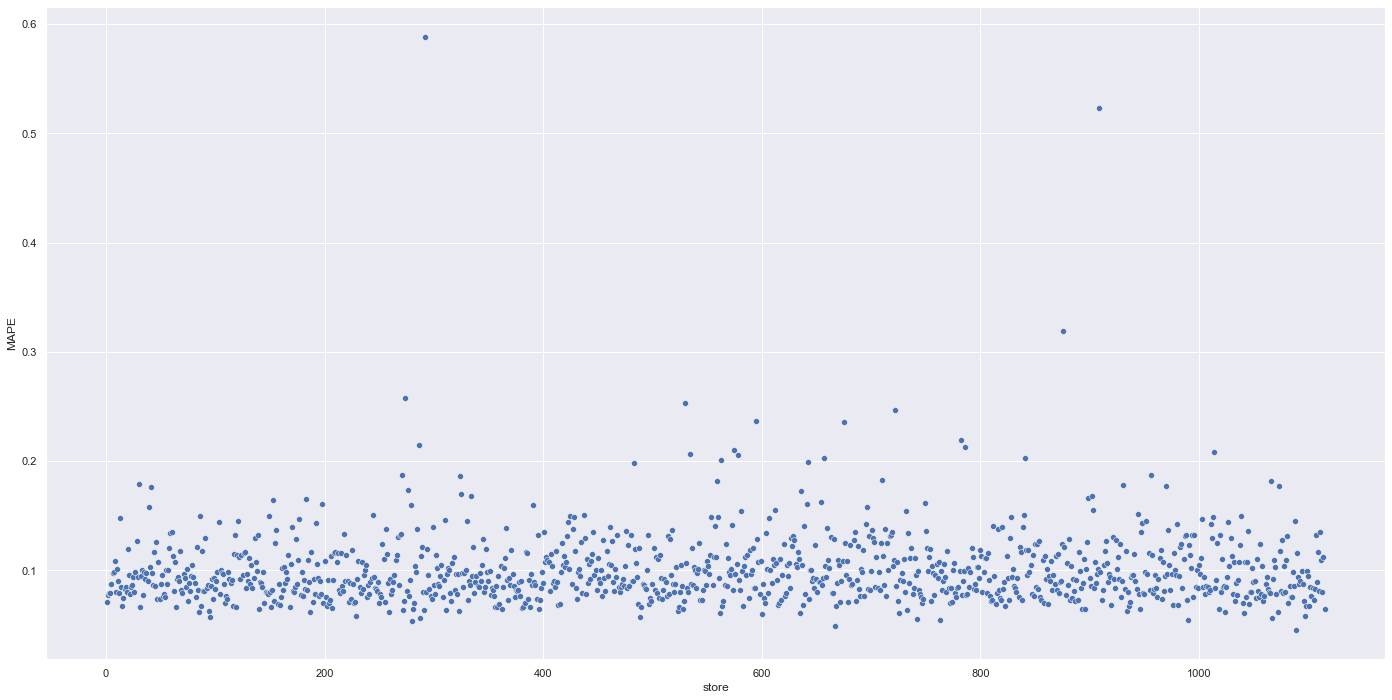

In [107]:
sns.scatterplot(x='store', y='MAPE', data=df09_bp)

## 9.2. Total Performance

In [108]:
df09_tp = df09_bp[['predictions', 'worst_scenario', 'best_scenario']].apply(
    lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0:'Values'})

df09_tp['Values'] = df09_tp['Values'].map('R${:,.2f}'.format)
df09_tp

,Scenario,Values
0,predictions,"R$284,728,032.00"
1,worst_scenario,"R$256,668,815.46"
2,best_scenario,"R$312,787,262.65"


## 9.3. Machine Learning Performance

In [109]:
df09['error'] = df09['sales'] - df09['predictions']
df09['error_rate'] = df09['predictions'] / df09['sales']

C:\Users\Miguel\AppData\Local\Temp/ipykernel_8732/2218209450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df09['error'] = df09['sales'] - df09['predictions']
C:\Users\Miguel\AppData\Local\Temp/ipykernel_8732/2218209450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df09['error_rate'] = df09['predictions'] / df09['sales']


C:\Users\Miguel\anaconda3\envs\dsemproducao_venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Miguel\anaconda3\envs\dsemproducao_venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


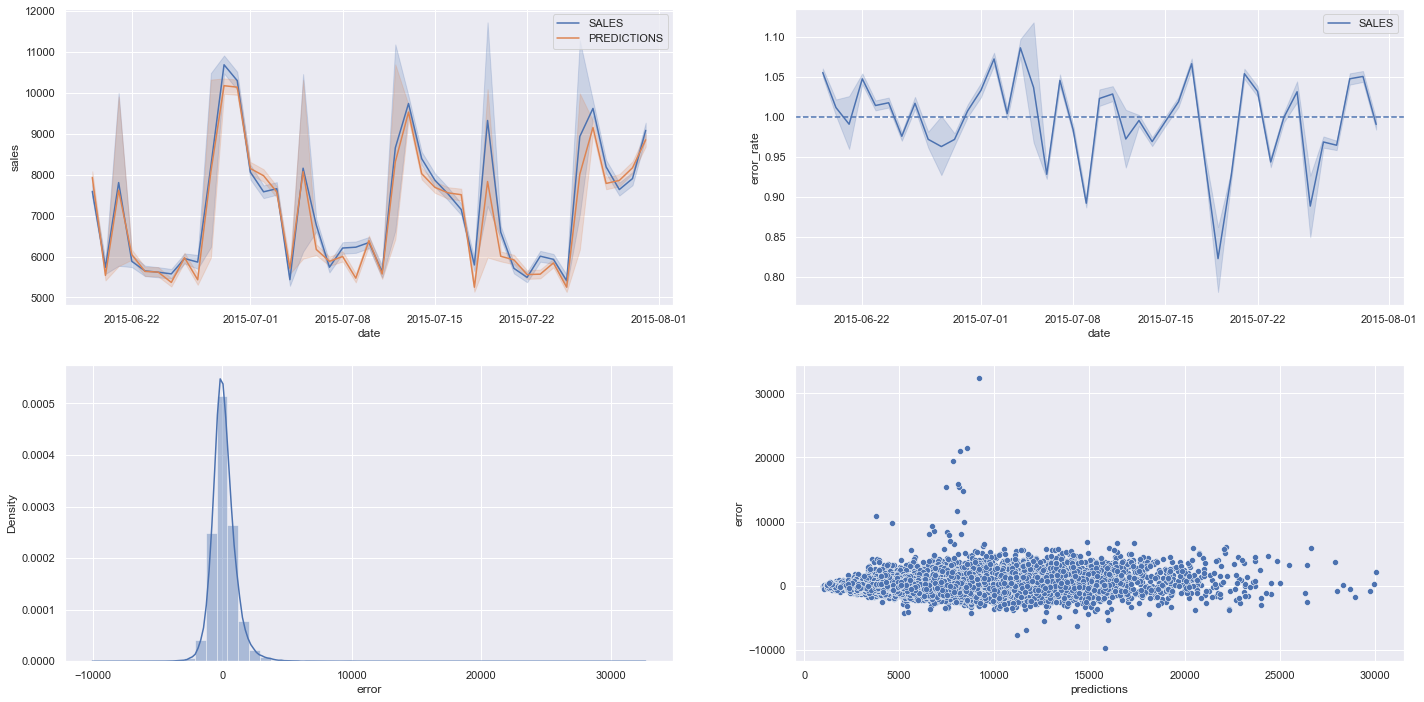

In [110]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df09,label='SALES')
sns.lineplot(x='date', y='predictions', data=df09, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df09,label='SALES')
plt.axhline(1, linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df09['error'])

plt.subplot(2,2,4)
sns.scatterplot(df09['predictions'], df09['error']);

# 10.0. PASSO 10 - DEPLOY MODEL

In [ ]:
# Save Trained Model
pickle.dump(model_xgb_tuned, open('../model/model_rossmann_l.pkl', 'wb'))

## 10.1. Rossmann Class

In [ ]:
import pickle
import pandas as pd
import numpy as np

from inflection import underscore


class Rossmann(object):

    def __init__(self):
        self.state = 1

        # competition_distance
        self.competition_distance_scaler = pickle.load(open('../parameter/competition_distance_scaler.pkl', 'rb'))
        # competition_time_month
        self.competition_time_month_scaler = pickle.load(open('../parameter/competition_time_month_scaler.pkl', 'rb'))
        # year
        self.year_scaler = pickle.load(open('../parameter/year_scaler.pkl', 'rb'))
        # promo_time_week
        self.promo_time_week_scaler = pickle.load(open('../parameter/promo_time_week_scaler.pkl', 'rb'))
        #state_holiday - One Hot Encoding
        pickle.load(open('../parameter/state_holiday_encoded.pkl', 'rb'))
        #store_type - Label Encoding
        self.store_type_encoding = pickle.load(open('../parameter/store_type_encoding.pkl', 'rb'))

    def data_cleaning(self, df01):

        # lower and separating by _
        df01.columns = df01.columns.to_series().apply(
            lambda x: underscore(x))

        # to date
        df01['date'] = pd.to_datetime(df01['date'])

        #competition_distance --> fill with a really big distante --> implies --> no competition
        df01['competition_distance'].fillna(75000 *
                                            3,
                                            inplace=True)

        #### The next 4 "since" attributes --> Filling the respective label ( month, year) of the sale date
        #### Because if since month = sale month --> the difference will be 0
        #competition_open_since_month --> fill with the month of the sale
        df01['competition_open_since_month'].fillna(
            df01.loc[df01['competition_open_since_month'].isna(),
                     'date'].dt.month,
            inplace=True)

        #competition_open_since_year --> fill with the year of the sale
        df01['competition_open_since_year'].fillna(
            df01.loc[df01['competition_open_since_year'].isna(),
                     'date'].dt.year,
            inplace=True)

        #promo2_since_week --> fill with the week of the sale
        df01['promo2_since_week'].fillna(
            df01.loc[df01['promo2_since_week'].isna(),
                     'date'].dt.isocalendar().week,
            inplace=True)

        #promo2_since_year --> fill with the year of the sale
        df01['promo2_since_year'].fillna(
            df01.loc[df01['promo2_since_year'].isna(), 'date'].dt.year,
            inplace=True)

        #promo_interval
        df01['promo_interval'] = df01['promo_interval'].str.replace(
            'Sept', 'Sep')  # en_US format
        df01['promo_interval'].fillna(
            0, inplace=True)  # there's no promo_interval

        #df01['sale_month'] = df01['date'].dt.strftime('%b') --> deletar
        # creating a column to know if the sale is in a promo month
        df01['is_promo'] = df01[['promo_interval', 'date']].apply(
            lambda x: 0 if x['promo_interval'] == 0 else 1
            if x['date'].strftime('%b') in x['promo_interval'] else 0,
            axis=1)

        df01['competition_open_since_month'] = df01[
            'competition_open_since_month'].astype('int64')
        df01['competition_open_since_year'] = df01[
            'competition_open_since_year'].astype('int64')

        df01['promo2_since_week'] = df01['promo2_since_week'].astype('int64')
        df01['promo2_since_year'] = df01['promo2_since_year'].astype('int64')

        return df01

    def feature_engineering(self, df02):

        # year
        df02['year'] = df02['date'].dt.year

        # month
        df02['month'] = df02['date'].dt.month

        # day
        df02['day'] = df02['date'].dt.day

        # week of year
        df02['week_of_year'] = df02['date'].dt.isocalendar().week

        # year week
        df02['year_week'] = df02['date'].dt.strftime('%Y-%V')

        # competition since
        df02['competition_since'] = pd.to_datetime(
            df02['competition_open_since_year'].astype(str) + '-' +
            df02['competition_open_since_month'].astype(str),
            format='%Y-%m')

        df02['competition_time_month'] = (
            (df02['date'] - df02['competition_since']) / 30).dt.days

        # promo since -- > needs a day of week to transform to date
        df02['promo_since'] = pd.to_datetime(
            df02['promo2_since_year'].astype(str) + '-' +
            df02['promo2_since_week'].astype(str) + '-0',
            format='%G-%V-%w')

        df02['promo_time_week'] = ((df02['date'] - df02['promo_since']) /
                                   7).dt.days  # how many weeks in promo

        # assorment
        dic_assorment = {'a': 'basic', 'b': 'extra', 'c': 'extended'}
        df02['assortment'] = df02['assortment'].replace(dic_assorment)

        # state holiday
        dic_holidays = {
            'a': 'public_holiday',
            'b': 'easter_holiday',
            'c': 'christmas',
            '0': 'regular_day'
        }
        df02['state_holiday'] = df02['state_holiday'].replace(dic_holidays)

        # removing promo_inverval
        df02 = df02.drop(columns=['promo_interval'])

        # filter line
        df02 = df02[df02['open'] != 0]

        # filter columns
        cols_drop = ['open']
        df02 = df02.drop(columns=cols_drop)

        return df02

    def data_prepatarion(self, df03):  
        
        # competition_distance --> outliers
        df03['competition_distance'] = self.rs_competition_distance.transform(df03[['competition_distance']].values)


        # competition_time_month
        df03['competition_time_month'] = self.rs_competition_time_month.transform(df03[['competition_time_month']].values)
        
        # year
        df03['year'] = self.minmax_year.transform(df03[['year']].values)

        # promo_time_week
        df03['promo_time_week'] = self.minmax_promo_time_week.transform(df03[['promo_time_week']].values)
        
        #state_holiday - One Hot Encoding
        state_holiday_encoded = self.one_hot_state_holiday.transform(df03['state_holiday'])
        columns_created = self.one_hot_state_holiday.get_feature_names()
        
        df03[columns_created] =  state_holiday_encoded.values
        df03 = df03.drop(columns=['state_holiday', columns_created[0]])
        
        
        #store_type - Label Encoding
        df03['store_type'] = self.le_store_type.transform(df03['store_type'])
        
        #assortment- Ordinal Encoding
        assortment_dict = {'basic':1,
                           'extra':2,
                           'extended':3}
        df03['assortment'] = df03['assortment'].map(assortment_dict)
        
        
        ########### Nature Transformation ###########
    
        # day_of_week
        len_day_of_week = 7
        df03['day_of_week_sin'] = df03['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/len_day_of_week)))
        df03['day_of_week_cos'] = df03['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/len_day_of_week)))

        # month
        len_month = 12
        df03['month_sin'] = df03['month'].apply(lambda x: np.sin(x*(2*np.pi/len_month)))
        df03['month_cos'] = df03['month'].apply(lambda x: np.cos(x*(2*np.pi/len_month)))

        # day
        len_day = 31
        df03['day_sin'] = df03['day'].apply(lambda x: np.sin(x*(2*np.pi/len_day)))
        df03['day_cos'] = df03['day'].apply(lambda x: np.cos(x*(2*np.pi/len_day)))

        # week_of_year
        len_week_of_year = 52
        df03['week_of_year_sin'] = df03['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/len_week_of_year)))
        df03['week_of_year_cos'] = df03['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/len_week_of_year)))

        df03 = df03.drop(columns=['day_of_week', 'month', 'day', 'week_of_year'])
        

        # cols selected by boruta
        cols_selected_boruta = [
            'store', 'promo', 'store_type', 'assortment',
            'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week',
            'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'day_sin',
            'day_cos', 'week_of_year_cos'
        ]

        #plus month sin and week of year sin
        cols_selected_boruta.extend(['month_sin', 'week_of_year_sin'])

        
        return df03[cols_selected_boruta]
    
    
    def get_prediction(self, model, original_data,test_data):
        # predictions
        pred = model.predict(test_data)
        
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2. API Handler

In [ ]:
from flask import Flask, request,Response
from rossmann.Rossmann import Rossmann
import pickle
import pandas as pd

# loading model
model = pickle.load(open('../model/model_rossmann_l.pkl', 'rb'))

# api
app = Flask(__name__)

@app.route('/')
def test_status():
    return {'status': 'ok'}

@app.route('/rossmann/predict', methods=['POST'])
def rossman_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json, dict): # unique line
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # multiple lines
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instantiate Rossmanclass
        pipeline = Rossmann()
        
    
        # data cleaning
        df_1 = pipeline.data_cleaning(test_raw)
        # feature engineering
        df_2 = pipeline.feature_engineering(df_1)
        # data prepatarion
        df_3 = pipeline.data_prepatarion(df_2)
        # predicition
        df_response = pipeline.get_prediction(model, test_raw, df_3)
        
        return df_response
        
    else:
        return Response('{No Data}', status=200, mimetype='application/json')
    
if __name__=='__main__':
    app.run('0.0.0.0')

## 10.3. API Tester

In [7]:
import requests

In [9]:
# loading test dataset
df10 = pd.read_csv('../../data/test.csv')

In [10]:
#df_store_raw = pd.read_csv('../../data/store.csv')

In [14]:
# merge
df_test = df10.merge(df_store_raw, on='Store')

# choose store for predction
df_test = df_test[df_test['Store'].isin([10 ,22, 24])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]

df_test = df_test.drop(columns=['Id'])

# # convert DataFrame to json
df_test = df_test.to_json(orient='records')

In [17]:
# API call
#url = ' https://rossman-prediction-sales.herokuapp.com/rossmann/predict'
url = 'https://rossmann-model-test01.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = df_test

r = requests.post(url, data=data, headers=header)
print(f'Status Code {r.status_code}')

Status Code 503


In [11]:
d1 = pd.DataFrame(r.json())
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()
d2

,store,prediction
0,10,225075.45752
1,22,181969.54248
2,24,370758.10498
